In [1]:
from __future__ import print_function, division
import numpy as np
import csv

import warnings
warnings.filterwarnings("ignore")
import os.path
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
import argparse
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import utils

device = 'cuda'
os.environ["CUDA_VISIBLE_DEVICES"] = "7" 
def get_image_location(name):
    
#     n = int(name) // 1000
#     n*=1000
#     folder = "%05d" % n
#     name = "%05d" % int(name)

#     return f"../../scratch/shared/ffhq-512/images/{folder}/"+name+".png"
    return f"../../../../../scratch/hl106/face_reco_fairness/data/image/seed{int(name):05d}.png"

def get_race(n):

    input_ = Image.open(get_image_location(str(n)))
    input_ = trans(input_)
    outputs = model_fair_7(input_.reshape(1, 3, 224, 224).cuda())[0]
    race_outputs = outputs[:7].cpu().detach().numpy()
    race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
    race_pred = np.argmax(race_score)
    
    gender_outputs = outputs[7:9].cpu().detach().numpy()
    gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
    gender_pred = np.argmax(gender_score)
    
    age_outputs = outputs[9:].cpu().detach().numpy()
    age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))
    age_pred = np.argmax(age_score)
    return [n, race_pred, race_score[race_pred], gender_pred, gender_score[gender_pred], age_pred, age_score[age_pred]]

def get_age(n):

    input_ = Image.open(get_image_location(str(n)))
    input_ = trans(input_)
    outputs = model_fair_7(input_.reshape(1, 3, 224, 224).cuda())[0]
    
    age_outputs = outputs[9:].cpu().detach().numpy()
    age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))
    age_pred = np.argmax(age_score)
    return [n, age_pred, age_score[age_pred]]

trans = transforms.Compose([
#         transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

model_fair_7 = torchvision.models.resnet34(pretrained=True)
model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
model_fair_7.load_state_dict(torch.load('../../../../scratch/hl106/pretrained_models/res34_fair_align_multi_7_20190809.pt'))
model_fair_7 = model_fair_7.to("cuda")
model_fair_7 = model_fair_7.eval()



In [176]:
import pdb

def get_smiling(n):

    input_ = Image.open(get_image_location(str(n)))
    input_ = trans(input_)
    outputs = model_s(input_.reshape(1, 3, 224, 224).cuda())[0]
    
    age_outputs = outputs.cpu().detach().numpy()
    age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))
    age_pred = np.argmax(age_score)
    return [n, age_pred, age_score[age_pred]]

smiling_transform = transforms.Compose([
#         transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


model_s = torch.load("models/hair_classifier_2.pt")
model_s.cuda()
model_s = model_s.eval()

In [177]:
tmp = []
for i in tqdm(range(0,10000)): 
    tmp.append(get_smiling(i))

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.64it/s]


In [ ]:
import csv
with open('/scratch/hl106/eg3d/out/eg3d_hair_labels_0_10000.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['image_number', 'race_group', 'race_group_confidence', 'age_group', 'age_group_confidence'])
    for i in tmp:
        writer.writerow(i)

In [33]:
y = []

In [34]:
import csv
with open('/scratch/hl106/eg3d/out/eg3d_race_labels_0_60000_fair7.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    next(spamreader)
    for row in spamreader:
        y.append(row)

In [760]:
race = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0, '6':0}
gender = {'0':0, '1':0}
for i in y:
    race[i[1]] += 1
#     gender[i[3]] += 1

In [761]:
print(race)

{'0': 42773, '1': 764, '2': 5126, '3': 6159, '4': 1786, '5': 1981, '6': 1411}


In [309]:
ys = [1 if i==1 else 0 for i in y]

In [79]:
x = []
for i in range(0, 60000):
    x.append(np.load(f"/scratch/hl106/face_reco_fairness/data/style/seed{i:05d}.npy"))
x = np.concatenate(x, axis=0)

In [52]:
data = []
race_labels = []
gender_labels = []
gender_scores = []
label_count = {'0':0, '1':0, '2':0, '3':0}
for d, label in zip(x, y):
    race = label[1]
    gender = label[3]
    if gender == 1:
        continue
    if label_count[race] < 1315:
        label_count[race] += 1
        data.append(d)
        race_labels.append(int(race))
        gender_labels.append(int(label[3]))
        gender_scores.append(float(label[4]))
    else:
        continue

In [793]:
labels = []
data  = []
cnt = 0
for l, d in zip(y, x):
    if int(l[1]) == 0 and cnt <= 5000:
        labels.append(0)
        data.append(d)
        cnt += 1
    elif int(l[1]) == 6:
        labels.append(1)
        data.append(d)

In [190]:
labels = []
data  = []
cnt = 0
for d, l in zip(x[:8000], y[:8000]):
    data.append(d)
    labels.append(int(l[1]))

In [191]:
from sklearn import svm
clf = svm.SVC(kernel="linear",class_weight='balanced')
clf.fit(np.array(data)[:,0], labels)

SVC(class_weight='balanced', kernel='linear')

In [273]:
from sklearn import svm
clf = svm.SVR(kernel="linear")
clf.fit(np.array(data)[:, 0], labels)

SVR(kernel='linear')

In [197]:
norm_w = clf.coef_ / np.linalg.norm(clf.coef_)
norm_i = clf.intercept_ / np.linalg.norm(clf.coef_)
np.save("svm/eg3d_norm_long_hair_w_0.npy", norm_w)
np.save('svm/eg3d_norm_long_hair_i_0.npy', norm_i)

In [71]:
import dnnlib
import legacy
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

network_pkl = '../../../../scratch/hl106/pretrained_models/eg3d_models/ffhq512-128.pkl'
# network_pkl = 'interfacegan/models/pretrain/stylegan_ffhq.pth'
# network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "../../../../scratch/hl106/pretrained_models/eg3d_models/ffhq512-128.pkl"...


In [77]:
x = []
for i in range(0, 60000):
    x.append(np.load(f"../../../../../scratch/hl106/face_reco_fairness/data/style/seed{i:05d}.npy"))
x = np.concatenate(x, axis=0)

# REDs

In [4]:
class Config():
    def __init__(self, step=1, batch=1, f=None, beta_f=[0.99], beta_c=[0.999], n_step=1, n_eig=1, save_dir=None, seed=1, dir_alg="reds", im_size=256, path_alg="local"):
        self.step = step
        self.batch = batch
        self.f = f
        self.beta_f = beta_f
        self.beta_c = beta_c
        self.n_step = n_step
        self.n_eig = n_eig
        self.save_dir = save_dir
        self.seed = seed
        self.dir_alg = dir_alg
        self.im_size = im_size
        self.path_alg = path_alg

In [160]:
models = [ 
          'models/male_classifier_bce.pt',
          'models/glasses_classifier_bce.pt',
          'models/hair_classifier_bce.pt',
#           'models/beard_classifier_bce.pt',
          'models/smiling_classifier_bce.pt',
          ]
funcs = []
for model in models:
    func = utils.im_to_attr(torch.load(model).to(device).eval(), device)
    funcs.append(func)

In [2]:
funcs = []
faceid_model = utils.load_faceid_model(device)
func = utils.face_to_id(faceid_model, device)
funcs.append(func)

seg_net = utils.load_face_segmenter(device)
mask_func = utils.mask_by_segmentation(seg_net, device, "hair")

filt_func = None
func = utils.im_to_vec(mask_func=mask_func, filt_func=filt_func) 
funcs.append(func)

In [10]:
import pdb

def get_local_directions(z, generator, funcs, config, two_sided=True):

    def jacobian_to_grammian(J, eps=1e-9):
        A = np.matmul(J.T, J)
        A += np.random.randn(*A.shape) * eps # To avoid any singular matrix issues, add noise.
        return A/np.linalg.norm(A)

    if config.dir_alg == 'rand':
        V = np.random.rand(z.shape[1], z.shape[1]) - 0.5
        V = V/np.linalg.norm(V, axis=0, keepdims=True)
    else:
        J = utils.get_jacobian( z, config.step, config.batch, generator, funcs, two_sided)
        
        Af = [ jacobian_to_grammian(Ji) for Ji in J[0:len(config.f)] ]
        Ac = [ jacobian_to_grammian(Ji) for Ji in J[len(config.f):] ]

        if config.dir_alg == 'maxc':
            V = utils.split_space_by_explained_variance(Ac[0], config.beta_c)[0]

        elif config.dir_alg == 'minf':
            V = utils.get_nullspace_intersection(Af, config.beta_f)

        elif config.dir_alg == 'reds':
            V = utils.get_REDs(Af, Ac, config.beta_f, config.beta_c)
        else:
            raise ValueError('Not a valid algorithm.')

    return V

In [6]:
def generate_traversals(z0, generator, funcs, config):

    # Get directions at seed point
    V0 = get_local_directions(z0, generator, funcs, config, True)
    config.n_eig = min(config.n_eig, V0.shape[1])

    # Image and latent-storing arrays
    I = utils.ImageGrid(config.im_size, 2*config.n_eig, config.n_step+1)
    Z = np.zeros((2*config.n_eig, config.n_step+1, z0.shape[-1]))

    # Get seed image
    im0, _ = utils.generate(z0, G)

    # Make paths
    for t in tqdm(range(config.n_eig*2)): # For each RED at seed point (pos/neg direction)
        I.insert(255*im0[0,...], t, 0) #Add starting image
        Z[t, 0, :] = z0

        v = V0[:, t//2] #Starting eigenvector
        if t%2 == 1: # positive or negative direction
            v *= -1

        for j in range(config.n_step):
            #print(t, j)
            if j > 0 and config.path_alg == 'local':
                Vi = get_local_directions(Z[t, j:j+1, :], generator, funcs, config, False)
                v_new = utils.project_onto_subspace(v, Vi)
                v = v_new if np.sum(v_new * v) > 0 else -v_new

            # Move to new location
            Z[t, j+1, :] = Z[t, j, :] + config.step * v
            im_cur, _ = utils.generate(Z[t, j+1:j+2, :], G)
            I.insert(255*im_cur[0,...], t, j+1) 

    # Save data 
    I.save(f'{config.save_dir}/{config.seed}.jpg')
    np.save(f'{config.save_dir}/{config.seed}_Z.npy', Z)

In [12]:
z0 = np.load(f'/scratch/hl106/eg3d/out/white_test_eg3d_15/seed_5022/white_male_w.npy')[0].reshape(1,-1)
config = Config(seed='5022wm_hair', f=[1], save_dir='tmp', im_size=512, step=2)
generate_traversals(z0, G, funcs, config)

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.72it/s]


In [13]:
def generate(z):

    from camera_utils import LookAtPoseSampler, FOV_to_intrinsics
    from torch_utils import misc
    from training.triplane import TriPlaneGenerator
    device = 'cuda'
    fov_deg = 18.837
    cam2world_pose = LookAtPoseSampler.sample(3.14/2, 3.14/2, torch.tensor([0, 0, 0.2], device=device), radius=2.7, device=device)
    intrinsics = FOV_to_intrinsics(fov_deg, device=device)
    z = torch.from_numpy(z).to(device)
    truncation_psi=0.7
    truncation_cutoff=14
    
    for angle_y, angle_p in [(0, -0.2)]:
        cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
        cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
        cam2world_pose = LookAtPoseSampler.sample(np.pi/2 + angle_y, np.pi/2 + angle_p, cam_pivot, radius=cam_radius, device=device)
        conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
        camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
        conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

#         ws = G.mapping(z, conditioning_params, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
        img = G.synthesis(z.reshape(1,14,512), camera_params)['image']
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu()
    return img[0]

In [344]:
def generate(z):

    from camera_utils import LookAtPoseSampler, FOV_to_intrinsics
    from torch_utils import misc
    from training.triplane import TriPlaneGenerator
    noise_mode = 'const'
    fov_deg = 18.837
    cam2world_pose = LookAtPoseSampler.sample(3.14/2, 3.14/2, torch.tensor([0, 0, 0.2], device=device), radius=2.7, device=device)
    intrinsics = FOV_to_intrinsics(fov_deg, device=device)
    z = torch.from_numpy(z).to(device)
    truncation_psi=0.7
    truncation_cutoff=14
    label = torch.zeros([1, G.c_dim], device=device)


    img = G(z.reshape(18,512), label, truncation_psi=truncation_psi, noise_mode=noise_mode)
#     img = G.synthesis(z.reshape(1,18,512), noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu()

    return img[0]

In [142]:
import PIL
os.makedirs(f'out/final_picked_pose/', exist_ok=True)
    
def generate_views(index, w, kwr, kwg):

    from camera_utils import LookAtPoseSampler, FOV_to_intrinsics
    from torch_utils import misc
    from training.triplane import TriPlaneGenerator
    device = 'cuda'
    fov_deg = 18.837
    cam2world_pose = LookAtPoseSampler.sample(3.14/2, 3.14/2, torch.tensor([0, 0, 0.2], device=device), radius=2.7, device=device)
    intrinsics = FOV_to_intrinsics(fov_deg, device=device)
    z = torch.from_numpy(w).to(device)
    truncation_psi=0.7
    truncation_cutoff=14
    angle_p = -0.2
    os.makedirs(f'out/final_picked_pose/seed_{index}', exist_ok=True)
    for angle_y, angle_p in [(np.pi*3/18, angle_p), (np.pi*1.5/18, angle_p), (0, angle_p), 
                             (-np.pi*1.5/18, angle_p), (-np.pi*3/18, angle_p),]:

        
        cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
        cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
        cam2world_pose = LookAtPoseSampler.sample(np.pi/2 + angle_y, np.pi/2 + angle_p, cam_pivot, radius=cam_radius, device=device)
        conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
        camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
        conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

#         ws = G.mapping(z, conditioning_params, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
        img = G.synthesis(z.reshape(1,14,512), camera_params)['image']
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu()
        PIL.Image.fromarray(img[0].numpy(), 'RGB').save(f'out/final_picked_pose/seed_{index}/{kwr}_{kwg}_y_{angle_y*18/np.pi}.png')
#     return img[0]

In [143]:
for seed in tt:
    sample_wm = np.load(f'out/white_test_eg3d_26/seed_{seed}/white_male_w.npy')
    sample_wf = np.load(f'out/white_test_eg3d_26/seed_{seed}/white_female_w.npy')
    sample_bm = np.load(f'out/white_test_eg3d_26/seed_{seed}/black_male_w.npy')
    sample_bf = np.load(f'out/white_test_eg3d_26/seed_{seed}/black_female_w.npy')
    sample_am = np.load(f'out/white_test_eg3d_26/seed_{seed}/asian_male_w.npy')
    sample_af = np.load(f'out/white_test_eg3d_26/seed_{seed}/asian_female_w.npy')
    
    generate_views(seed, sample_wm, 'white', 'male')
    generate_views(seed, sample_wf, 'white', 'female')
    generate_views(seed, sample_bm, 'black', 'male')
    generate_views(seed, sample_bf, 'black', 'female')
    generate_views(seed, sample_am, 'asian', 'male')
    generate_views(seed, sample_af, 'asian', 'female')

In [102]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk('out/white_test_eg3d_26/merged'):
    f.extend(filenames)
    break
target_seeds = []
for name in f:
    target_seeds.append(int(name[4:9]))
target_seeds.sort()

In [201]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk('/scratch/hl106/eg3d/test_image_pairs_2'):
    f.extend(filenames)
    break


In [204]:
from os import walk

f2 = []
for (dirpath, dirnames, filenames) in walk('/scratch/hl106/eg3d/test_image_pairs'):
    f2.extend(filenames)
    break

In [208]:
cnt = 0
tmp = []
for i in f2:
    if i not in f:
        tmp.append(i)
tmp

['eg3d_30087_whitefemale_glasses_0__43580_whitefemale_glasses_1.png',
 'eg3d_30087_whitefemale_glasses_0__43580_whitefemale_glasses_0.png',
 'eg3d_30087_whitefemale_glasses_0__33311_whitefemale_glasses_1.png',
 'eg3d_30087_whitefemale_glasses_0__33311_whitefemale_glasses_0.png',
 'eg3d_30087_whitefemale_glasses_0__34533_whitefemale_glasses_1.png',
 'eg3d_30087_whitefemale_glasses_0__34533_whitefemale_glasses_0.png',
 'eg3d_30292_whitefemale_glasses_0__46731_whitefemale_glasses_1.png',
 'eg3d_30292_whitefemale_glasses_0__46731_whitefemale_glasses_0.png',
 'eg3d_30292_whitefemale_glasses_0__48773_whitefemale_glasses_1.png',
 'eg3d_30292_whitefemale_glasses_0__48773_whitefemale_glasses_0.png',
 'eg3d_30292_whitefemale_glasses_0__51747_whitefemale_glasses_1.png',
 'eg3d_30292_whitefemale_glasses_0__51747_whitefemale_glasses_0.png',
 'eg3d_30742_whitefemale_glasses_0__30087_whitefemale_glasses_1.png',
 'eg3d_30742_whitefemale_glasses_0__30087_whitefemale_glasses_0.png',
 'eg3d_30742_whitefe

# Max-min clustering

In [111]:
mesh_model = utils.load_facemesh_model()
mesh_func = utils.face_to_mesh('all', mesh_model)

In [117]:
race = ['white', 'black', 'asian']
gender = ['male', 'female']

seeds_mesh = {}
for seed in target_seeds:
    seeds_mesh[seed] = {}
    for r in race:
        for g in gender:
            test_img = cv2.imread(f'out/white_test_eg3d_26/seed_{seed}/{r}_{g}.png')
            mesh = mesh_func(test_img[np.newaxis,:])
            seeds_mesh[seed][f'{r}_{g}'] = mesh

In [118]:
def get_min_dist(picked_seeds, curr_seed):
    all_dist = []
    for t in picked_seeds:
        d = []
        for r in race:
            for g in gender:
                curr_dist = np.linalg.norm(seeds_mesh[curr_seed][f'{r}_{g}'] - seeds_mesh[t][f'{r}_{g}'])
                d.append(curr_dist)
        all_dist.append(np.min(d))
    return np.min(all_dist)

In [123]:
picked_seeds = []
picked_seeds.append(target_seeds[0])

for i in tqdm(range(99)):
    curr_seed = list(set(target_seeds) - set(picked_seeds))
    all_dist = []
    for idx, j in enumerate(curr_seed):
        all_dist.append(get_min_dist(picked_seeds, j))
    picked_seeds.append(curr_seed[np.argmax(all_dist)])
picked_seeds.sort()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.72it/s]


In [138]:
import pickle


with open('picked_seeds.data', 'wb') as filehandle:
    # Store the data as a binary data stream
    pickle.dump(picked_seeds, filehandle)

In [139]:
import pickle

with open('picked_seeds.data', 'rb') as filehandle:
    # Read the data as a binary data stream
    tt = pickle.load(filehandle)

In [14]:
gender_w_0 = np.load('svm/eg3d_norm_gender_w_0.npy')
gender_i_0 = np.load('svm/eg3d_norm_gender_i_0.npy')

black_w_0 = np.load('svm/eg3d_norm_white_black_w_0_fair7.npy')
black_i_0 = np.load('svm/eg3d_norm_white_black_i_0_fair7.npy')

asian_w_0 = np.load('svm/eg3d_norm_white_asian_w_0_fair7.npy')
asian_i_0 = np.load('svm/eg3d_norm_white_asian_i_0_fair7.npy')

seasian_w_0 = np.load('svm/eg3d_norm_white_seasian_w_0_fair7.npy')
seasian_i_0 = np.load('svm/eg3d_norm_white_seasian_i_0_fair7.npy')

latino_w_0 = np.load('svm/eg3d_norm_white_latino_w_0_fair7.npy')
latino_i_0 = np.load('svm/eg3d_norm_white_latino_i_0_fair7.npy')

indian_w_0 = np.load('svm/eg3d_norm_white_indian_w_0_fair7.npy')
indian_i_0 = np.load('svm/eg3d_norm_white_indian_i_0_fair7.npy')

mestern_w_0 = np.load('svm/eg3d_norm_white_meastern_w_0_fair7.npy')
mestern_i_0 = np.load('svm/eg3d_norm_white_meastern_i_0_fair7.npy')

age_w_0 = np.load('svm/eg3d_norm_age_w_0.npy')
age_i_0 = np.load('svm/eg3d_norm_age_i_0.npy')

smiling_w_0 = np.load('svm/eg3d_norm_smiling_w_0.npy')
smiling_i_0 = np.load('svm/eg3d_norm_smiling_i_0.npy')

hair_w_0 = np.load('svm/eg3d_norm_hair_w_0.npy')
hair_i_0 = np.load('svm/eg3d_norm_hair_i_0.npy')

makeup_w_0 = np.load('svm/eg3d_norm_makeup_w_0.npy')
makeup_i_0 = np.load('svm/eg3d_norm_makeup_i_0.npy')

glasses_w_0 = np.load('svm/eg3d_norm_glasses_w_0.npy')
glasses_i_0 = np.load('svm/eg3d_norm_glasses_i_0.npy')

beard_w_0 = np.load('svm/eg3d_norm_beard_w_0.npy')
beard_i_0 = np.load('svm/eg3d_norm_beard_i_0.npy')

In [15]:
def orthogonalize(v0, planes):

    A = np.zeros((max(v0.shape), len(planes)))
    for i,h in enumerate(planes):
        A[:, i] = h
        
    Q,R = np.linalg.qr(A)

    u = v0.copy()
    for i in range(len(planes)):
        u -= proj(Q[:,i], u)

    return normalize(u)
    

def normalize(u):
    return u/np.linalg.norm(u)

def proj(u, v):
    return u * np.sum(u * v) / np.sum( u * u)

In [16]:
new_black_w = orthogonalize(black_w_0, [
                                    gender_w_0,
                                    asian_w_0,
                                    seasian_w_0,
                                    latino_w_0,
                                    indian_w_0,
                                    mestern_w_0,
                                    age_w_0,
                                    smiling_w_0,
                                    glasses_w_0,
                                    hair_w_0,
                                            ])

new_asian_w = orthogonalize(asian_w_0, [
                                    gender_w_0,
                                    black_w_0,
                                    seasian_w_0,
                                    latino_w_0,
                                    indian_w_0,
                                    mestern_w_0,
                                    age_w_0,
                                    smiling_w_0,
                                    glasses_w_0,
                                    hair_w_0,
                                            ])

new_gender_w = orthogonalize(gender_w_0, [
                                    asian_w_0,
                                    black_w_0,
                                    seasian_w_0,
                                    latino_w_0,
                                    indian_w_0,
                                    mestern_w_0,
                                    age_w_0,
                                    smiling_w_0,
                                    glasses_w_0,
                                    hair_w_0,
                                            ])
new_hair_w = orthogonalize(hair_w_0, [
                                    asian_w_0,
                                    black_w_0,
                                    seasian_w_0,
                                    latino_w_0,
                                    indian_w_0,
                                    mestern_w_0,
                                    age_w_0,
                                    smiling_w_0,
                                    glasses_w_0,
                                    gender_w_0,
                                            ])

In [101]:
np.dot(new_hair_w[0], hair_w_0[0])

0.9649089905413517

In [708]:
from interfacegan.utils.manipulator import project_boundary

primal = np.load('svm/eg3d_norm_beard_w_0.npy')
cond1 = np.load('svm/eg3d_norm_gender_w_0.npy')
cond2 = np.load('svm/eg3d_norm_hair_w_0.npy')

new_smiling_w = project_boundary(primal, cond1)

In [796]:
def project_boundary_n(primal, cond):
    for c in cond:
        primal = project_boundary(primal, c)
    return primal

In [17]:
def get_dist(d, w, i):
#     print(np.dot(d, w.reshape(512)) + i)
    return np.dot(d, w.reshape(512)) + i

In [67]:
def generate(z):

    from camera_utils import LookAtPoseSampler, FOV_to_intrinsics
    from torch_utils import misc
    from training.triplane import TriPlaneGenerator
    device = 'cuda'
    fov_deg = 18.837
    cam2world_pose = LookAtPoseSampler.sample(3.14/2, 3.14/2, torch.tensor([0, 0, 0.2], device=device), radius=2.7, device=device)
    intrinsics = FOV_to_intrinsics(fov_deg, device=device)
    z = torch.from_numpy(z).to(device)
    truncation_psi=0.7
    truncation_cutoff=14
    
    for angle_y, angle_p in [(0, -0.2)]:
        cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
        cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
        cam2world_pose = LookAtPoseSampler.sample(np.pi/2 + angle_y, np.pi/2 + angle_p, cam_pivot, radius=cam_radius, device=device)
        conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
        camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
        conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

#         ws = G.mapping(z, conditioning_params, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
        img = G.synthesis(z.reshape(1,14,512), camera_params)['image']
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu()
    return img[0]

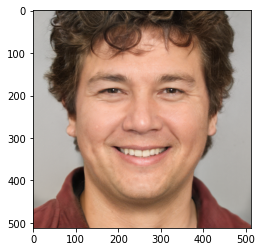

In [80]:
# for i in [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]:
sample = x[5336]
plt.imshow(generate(sample))

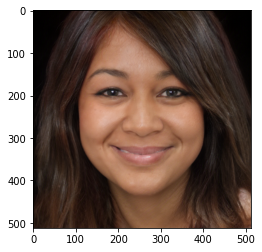

In [196]:
# coef0 = 2 - get_dist(sample[0], asian_w_0, asian_i_0)
# print(coef0)
new_sample = np.zeros((14,512))
new_sample[0:14] = sample[0:14] - 2*norm_w
plt.imshow(generate(new_sample))

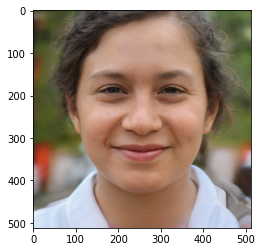

In [52]:
coef0 = 1-get_dist(sample[0], gender_w_0, gender_i_0)
new_sample = np.zeros((14,512))
new_sample[0:14] = sample[0:14]+coef0*gender_w_0
plt.imshow(generate(new_sample))

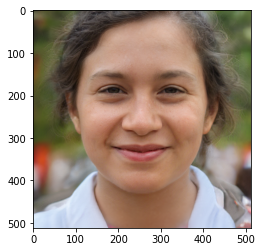

In [70]:
coef0 = 0.8-get_dist(sample[0], norm_w, norm_i)
new_sample = np.zeros((14,512))
new_sample[0:14] = sample[0:14]+coef0*norm_w
plt.imshow(generate(new_sample))

In [ ]:
model_fair_4 = torchvision.models.resnet34(pretrained=True)
model_fair_4.fc = nn.Linear(model_fair_4.fc.in_features, 18)
model_fair_4.load_state_dict(torch.load('../../../../scratch/hl106/pretrained_models/res34_fair_align_multi_4_20190809.pt'))
model_fair_4 = model_fair_4.to("cuda")
model_fair_4.eval()

In [167]:
trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [187]:
def search_race_coef(z, w, race=1, alpha=0.2):

    for i in range(50):
        input_ = generate(z+alpha*w)
        input_ = trans(input_.numpy())
        output = model_fair_4(input_.reshape(1, 3, 224, 224).cuda())[0]
        race_outputs = output[:4].cpu().detach().numpy()
        race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
        race_score = race_score[race]
        if race_score <= 0.95:
            alpha += 0.1
        else:
            return alpha
        
    return alpha

In [185]:
def search_gender_coef(z, w, race=1, alpha=0.2):

    for i in range(50):
        input_ = generate(z+alpha*w)
        input_ = trans(input_.numpy())
        output = model_fair_4(input_.reshape(1, 3, 224, 224).cuda())[0]
        race_outputs = output[7:9].cpu().detach().numpy()
        race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
        race_score = race_score[race]
        if race_score <= 0.9:
            alpha += 0.1
        else:
            return alpha
        
    return alpha

In [54]:
def get_age(n):

    input_ = Image.open(get_image_location(str(n)))
    input_ = trans(input_)
    outputs = model_fair_4(input_.reshape(1, 3, 224, 224).cuda())[0]
    
    age_outputs = outputs[9:].cpu().detach().numpy()
    age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))
    age_pred = np.argmax(age_score)
    return age_pred

In [702]:
for i in [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]:
# for i in [5494]:
    size = [512, 512]
    new_im = PIL.Image.new('RGB', (5*size[0],6*size[0]), (512,512,512))
    
    for j, race in enumerate(['white', 'black', 'asian']):
        for k, gender in enumerate(['male', 'female']):
            for l, a in enumerate([-2,0,2,4,6]):
                img = PIL.Image.open(f'out/picked_hair/seed_{i}/{race}_{gender}_hair_{a}.png')
                new_im.paste(img, (l*size[0], (2*j+k)*size[0]))
    new_im.save(f'out/picked_hair/seed{i}.png')

In [447]:
def get_age_strips(sample, seed, race='white', gender='male'):
    os.makedirs(f'out/picked_age/seed_{seed}', exist_ok=True)
    for i in [-0.5, 1.1, 1.7, 2.3, 2.9, 3.5, 4.1, 4.7, 5.3]:
        
        coef0 = i-get_dist(sample[0], new_age_w, age_i_0)
        new_sample = np.zeros((14,512))
        new_sample[0:14] = sample[0:14] + coef0*new_age_w - 1*(i<0)*gender_w_0
        
        img = generate(new_sample)
        PIL.Image.fromarray(img.numpy(), 'RGB').save(f'out/picked_age/seed_{seed}/{race}_{gender}_a_{i}_o.png')

In [ ]:
def get_glasses_strips(sample, seed, race='white', gender='male'):
    os.makedirs(f'out/picked_glasses/seed_{seed}', exist_ok=True)
    for i in [0, 6]:
        
        coef0 = i-get_dist(sample[0], glasses_w_0, glasses_i_0)
        new_sample = np.zeros((14,512))
        
        if race == 'black':
            coef0 += 2
        if gender == 'female':
            if seed not in [5916, 5840, 5783]:
                coef0 += 1
        if seed in [5840, 5783]:
            coef0 -= 3.5
        
        if seed == 5494:
            if race == 'asian':
                if gender == 'male': # asian male
                    new_sample[0:14] = sample[0:14] + (coef0-1)*glasses_w_0 + 1*asian_w_0
                else: # asian female
                    new_sample[0:14] = sample[0:14] + coef0*glasses_w_0 + 2*gender_w_0 + 2*asian_w_0
            elif gender == 'female': # other female
                new_sample[0:14] = sample[0:14] + coef0*glasses_w_0 + 2*gender_w_0
            else: # other male
                new_sample[0:14] = sample[0:14] + coef0*glasses_w_0 
        else:  
            new_sample[0:14] = sample[0:14] + coef0*glasses_w_0
        
        img = generate(new_sample)
        PIL.Image.fromarray(img.numpy(), 'RGB').save(f'out/picked_glasses/seed_{seed}/{race}_{gender}_g_{i}.png')

In [700]:
def get_hair_strips(sample, seed, race='white', gender='male'):
    os.makedirs(f'out/picked_hair/seed_{seed}', exist_ok=True)
    for i in [-2, 0, 2, 4, 6]:
        
        if race in ['black', 'asian']:
            if i > 0:
                coef0 += 2 
        coef0 = i-get_dist(sample[0], new_hair_w, age_i_0)
        new_sample = np.zeros((14,512))
        new_sample[0:14] = sample[0:14] + coef0*new_hair_w - 0.5*(i<0)*gender_w_0
        
        img = generate(new_sample)
        PIL.Image.fromarray(img.numpy(), 'RGB').save(f'out/picked_hair/seed_{seed}/{race}_{gender}_hair_{i}.png')

In [697]:
def get_smiling_strips(sample, seed, race='white', gender='male'):
    os.makedirs(f'out/picked_smiling/seed_{seed}', exist_ok=True)
    for i in [0,1,2,3,4]:
        new_sample = np.zeros((14,512))
        coef0 = i-get_dist(sample[0], new_smiling_w, age_i_0)
        
        if race == 'black':
            coef0 -= 1
        else:
            coef0 += 1
        
        if race == 'asian':
            if gender == 'male':
                new_sample[0:14] = sample[0:14] + coef0*new_smiling_w - 0.5*(i<0)*gender_w_0 - 2*glasses_w_0
            else:
                 new_sample[0:14] = sample[0:14] + coef0*new_smiling_w - 0.5*(i<0)*gender_w_0 - 2*glasses_w_0
        else:
            new_sample[0:14] = sample[0:14] + coef0*new_smiling_w - 0.5*(i<0)*gender_w_0
        
        img = generate(new_sample)
        PIL.Image.fromarray(img.numpy(), 'RGB').save(f'out/picked_smiling/seed_{seed}/{race}_{gender}_smiling_{i}.png')

In [84]:
# eyeglasses_model = torch.load('models/glasses_classifier_1.pt')

def race_gender_age_check(n):
    
    races = [[0], [1], [3,4]]
    genders = [[0], [1]]
    for r, race in enumerate(['white', 'black', 'asian']):
        for g, gender in enumerate(['male', 'female']):
            input_ = Image.open(f'out/white_test_eg3d_26/seed_{n}/{race}_{gender}.png')
            input_ = trans(input_)
            outputs = model_fair_7(input_.reshape(1, 3, 224, 224).cuda())[0]
            race_outputs = outputs[:7].cpu().detach().numpy()
            race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
            race_pred = np.argmax(race_score)

            gender_outputs = outputs[7:9].cpu().detach().numpy()
            gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
            gender_pred = np.argmax(gender_score)

            age_outputs = outputs[9:].cpu().detach().numpy()
            age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))
            age_pred = np.argmax(age_score)
            
#             eg_outputs = eyeglasses_model(input_.reshape(1, 3, 224, 224).cuda())[0].cpu().detach().numpy()
#             eg_score = np.exp(eg_outputs) / np.sum(np.exp(eg_outputs))
#             eg_pred = np.argmax(eg_score)
            
#             if eg_pred != 0:
#                 return False
            if race_pred not in races[r]:
                return False
            if age_pred not in [2,3,4]:
                return False
            if gender_pred not in genders[g]:
                return False
            
    return True

In [55]:
len(y)

60000

In [85]:
import PIL
import pdb
import shutil

# os.makedirs(f'out/picked_hair', exist_ok=True)
out = 'white_test_eg3d_26'
os.makedirs(f'out/{out}', exist_ok=True)
os.makedirs(f'out/{out}/merged', exist_ok=True)
cnt = 0
for i in range(30000, 60000):
    current = y[i]
    race = int(current[1])
    race_score = float(current[2])
    gender = int(current[3])
    gender_score = float(current[4])
    age = get_age(i)[1]
    if age not in [3]:
        continue
    if race != 0:
        continue
    if race_score <= 0.9:
        continue
    else:
        if gender == 0 and gender_score >= 0.9:
            
            os.makedirs(f'out/{out}/seed_{i}', exist_ok=True)
            sample=x[i]
            sample -= 2*glasses_w_0
            sample -= 2*smiling_w_0
            
            #white
            im_w_m = generate(sample)
#             get_hair_strips(sample, seed=seed)
            np.save(f'out/{out}/seed_{i}/white_male_w.npy', sample)
            
            c0 = 1.2-get_dist(sample[0], gender_w_0, gender_i_0)
            new_sample = np.zeros((14,512))
            new_sample[0:14] = sample[0:14]+c0*new_gender_w
            im_w_f = generate(new_sample)
#             get_hair_strips(new_sample, seed=seed, race='white', gender='female')
            np.save(f'out/{out}/seed_{i}/white_female_w.npy', new_sample)
            
            #black
            c0 = 2-get_dist(sample[0], black_w_0, black_i_0)
            new_sample_1 = np.zeros((14,512))
            new_sample_1[0:14] = sample[0:14]+c0*black_w_0-2*new_gender_w
            im_b_m = generate(new_sample_1)
#             get_hair_strips(new_sample_1, seed=seed, race='black', gender='male')
            np.save(f'out/{out}/seed_{i}/black_male_w.npy', new_sample_1)
            
            c0 = 1.2-get_dist(new_sample_1[0], gender_w_0, gender_i_0)
            new_sample_2 = np.zeros((14,512))
            new_sample_2[0:14] = new_sample_1[0:14]+c0*new_gender_w
            im_b_f = generate(new_sample_2)
#             get_hair_strips(new_sample_2,seed=seed, race='black', gender='female')
            np.save(f'out/{out}/seed_{i}/black_female_w.npy', new_sample_2)
            
            #asian
            c0 = 2.0-get_dist(sample[0], asian_w_0, asian_i_0)
            new_sample_1 = np.zeros((14,512))
            new_sample_1[0:14] = sample[0:14]+c0*asian_w_0-1.5*new_gender_w-1.5*glasses_w_0+1*age_w_0
            im_a_m = generate(new_sample_1)
#             get_hair_strips(new_sample_1, seed=seed, race='asian', gender='male')
            np.save(f'out/{out}/seed_{i}/asian_male_w.npy', new_sample_1)
            
            c0 = 1.2-get_dist(new_sample_1[0], gender_w_0, gender_i_0)
            new_sample_2 = np.zeros((14,512))
            new_sample_2[0:14] = new_sample_1[0:14]+c0*new_gender_w
            im_a_f = generate(new_sample_2)
#             get_hair_strips(new_sample_2,seed=seed, race='asian', gender='female')
            np.save(f'out/{out}/seed_{i}/asian_female_w.npy', new_sample_2)
            
            
            
            PIL.Image.fromarray(im_w_m.numpy(), 'RGB').save(f'out/{out}/seed_{i}/white_male.png')
            PIL.Image.fromarray(im_w_f.numpy(), 'RGB').save(f'out/{out}/seed_{i}/white_female.png')
            PIL.Image.fromarray(im_b_m.numpy(), 'RGB').save(f'out/{out}/seed_{i}/black_male.png')
            PIL.Image.fromarray(im_b_f.numpy(), 'RGB').save(f'out/{out}/seed_{i}/black_female.png')
            PIL.Image.fromarray(im_a_m.numpy(), 'RGB').save(f'out/{out}/seed_{i}/asian_male.png')
            PIL.Image.fromarray(im_a_f.numpy(), 'RGB').save(f'out/{out}/seed_{i}/asian_female.png')
            
            if race_gender_age_check(i):
                size = PIL.Image.open(f'out/{out}/seed_{i}/asian_female.png').size
                new_im = PIL.Image.new('RGB', (3*size[0],2*size[0]), (512,512,512))

                wm = PIL.Image.open(f'out/{out}/seed_{i}/white_male.png')
                wf = PIL.Image.open(f'out/{out}/seed_{i}/white_female.png')
                bm = PIL.Image.open(f'out/{out}/seed_{i}/black_male.png')
                bf = PIL.Image.open(f'out/{out}/seed_{i}/black_female.png')
                am = PIL.Image.open(f'out/{out}/seed_{i}/asian_male.png')
                af = PIL.Image.open(f'out/{out}/seed_{i}/asian_female.png')

                new_im.paste(wm, (0,0))
                new_im.paste(wf, (0,size[0]))

                new_im.paste(bm, (size[0],0))
                new_im.paste(bf, (size[0],size[0]))

                new_im.paste(am, (2*size[0],0))
                new_im.paste(af, (2*size[0],size[0]))
                new_im.save(f'out/{out}/merged/seed{i}.png')
                cnt += 1

            else:
                shutil.rmtree(f'out/{out}/seed_{i}')
        
    if cnt == 500:
        break

In [94]:
import cv2

for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        imgs = []
        for i in [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]:
            imgs.append(cv2.imread(f'out/picked_3/seed_{5336}/{race}_{gender}_y_{i}.png'))
        im_h = cv2.hconcat(imgs)
        # show the output image
        cv2.imwrite(f'plots/example_imgs_poses/seed_5336_{race}_{gender}.jpeg', im_h)

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


In [ ]:
# https://live.watchnbastreams.com/live/1/

# basic plots

In [580]:
feat1 = img2feat(net, f'out/picked_3/seed_{5471}/asian_male_y_{0.0}.png')

In [587]:
feat2 = img2feat(net, f'out/picked_3/seed_{5336}/black_female_y_{0.0}.png')

In [588]:
np.dot(feat1, feat2)

0.19694377

In [5]:
import cv2
import torch
from iresnet import iresnet34, iresnet18, iresnet50

weight = '/scratch/hl106/pretrained_models/R50_Glint360k_cosface.pth'
net = iresnet50(fp16=False)
net.load_state_dict(torch.load(weight))
net.eval()
net.cuda()

def img2feat(net, file_name):
    img = cv2.imread(file_name)
    img = cv2.resize(img, (112, 112))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float().cuda()
    img.div_(255).sub_(0.5).div_(0.5)

    
    feat = net(img).cpu().detach().numpy()
    feat /= np.linalg.norm(feat)
    return feat.reshape(512)

In [6]:
net

IResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=64)
  (layer1): Sequential(
    (0): IBasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): IBas

In [385]:
angles = [-3.0, -1.5, 0.0, 1.5, 3.0]
dist_dict = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        dist_dict[f'{race}_{gender}'] = {i:[] for i in range(5)}
#         for seed in [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]:
        for seed in target_seeds:
#             for i in range(8):
            for j in range(5):
                feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed}/{race}_{gender}_y_{0.0}_o2_rm_bg.png')
                feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed}/{race}_{gender}_y_{angles[j]}_o2_rm_bg.png')
                dist_dict[f'{race}_{gender}'][j].append(np.dot(feat1, feat2))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:51<00:00, 137.23s/it]


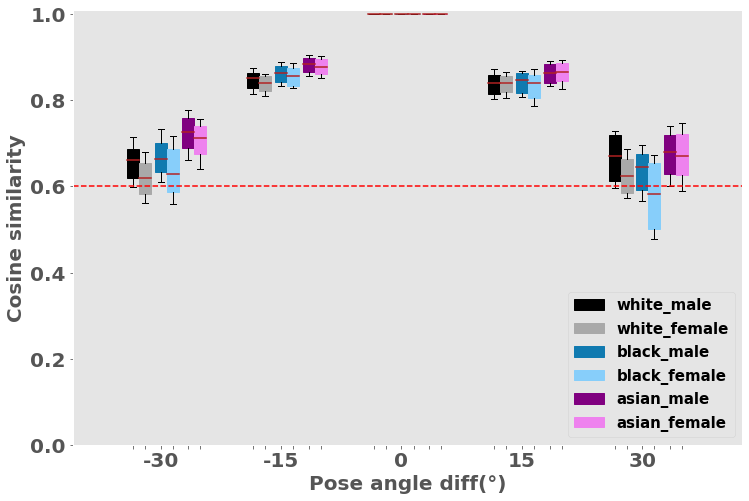

In [387]:
colors = ['black', 'darkgrey', 'xkcd:nice blue', 'lightskyblue', 'purple', 'violet']
pairs = ['white_male', 'white_female', 'black_male', 'black_female', 'asian_male', 'asian_female', ]
fig4, ax4 = plt.subplots(figsize=(12,8))
# ax4.set_title('Cosine similarity-pose: same race/gender same seed R34_glint360k', fontsize=30)
angles = [-30, -15, 0, 15, 30]
non_angles = ['']*5
boxes = []
for i in range(6):
    curr_data = np.zeros((100,5))
    for j in range(5):
        curr_data[:,j] = dist_dict[pairs[i]][j]
    if i == 2:
        box1 = ax4.boxplot(np.array(curr_data), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 
                               4.1+0.1*i+0.03*(i//2)],
                    widths=0.1, 
                    labels=angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )

    else:
         box1 = ax4.boxplot(np.array(curr_data), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 
                               4.1+0.1*i+0.03*(i//2)],
                    widths=0.1,
                    labels=non_angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )
    boxes.append(box1)
    
legend_properties = {'weight':'bold', 'size':15}
for i in range(6): 
    ax4.legend([boxes[i]["boxes"][0] for i in range(6)], [pairs[i] for i in range(6)], loc='lower right', prop=legend_properties)

# ax4.set_facecolor("gai")
ax4.set_ylim(0,1.01)
ax4.grid()
ax4.axhline(y=0.6, color='red', linestyle='--')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
ax4.set_xlabel('Pose angle diff(°)', fontsize=20, fontweight='bold')
ax4.set_ylabel('Cosine similarity', fontsize=20, fontweight='bold')
plt.savefig("final_plots/pose/same_seed_same_race_gender_cos_similarity_pose_r34_glint360k_15_85_ci.jpg", bbox_inches = "tight")

In [378]:
ax4.get_yticks()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2])

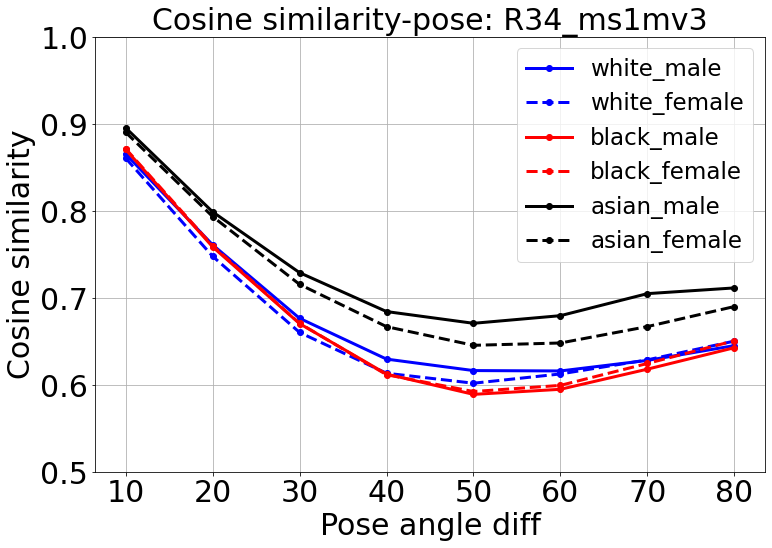

In [364]:
# set width of bar
barWidth = 0.10
# fig = plt.subplots(figsize =(12, 8))
# fig, ax = plt.subplots(3, 3, figsize=(5.6*9, 4.2*9))
# colors = ['#be254a', '#dc484c', '#ef6645', '#f88c51', '#fdb365', '#fed27f', '#feeb9d', '#fffebe', 
# '#f0f9a7', '#d8ef9b', '#b3e0a2', '#89d0a4', '#60bba8', '#3f97b7', '#4273b3']
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(12, 8))
cnt = 1
x_labels = [10, 20, 30, 40, 50, 60, 70, 80]
x_range = [i for i in range(1, 9)]

for race in ['white', 'black', 'asian']:
    for gender in ['male', 'female']:
        curr_data = []
        for i in range(1, 9):
            curr_data.append(np.mean(dist_dict[f'{race}_{gender}'][i]))
        
        if gender == 'male':
            plt.plot( x_range, curr_data, '-o', label =f'{race}_{gender}', linewidth=3, color=colors[(cnt-1)//2])
        else:
            plt.plot( x_range, curr_data, '-o', label =f'{race}_{gender}', linewidth=3, color=colors[(cnt-1)//2], linestyle='dashed')
        
        cnt+=1
        
plt.ylim(0.5, 1) 
plt.ylabel('Cosine similarity', fontsize=30)
plt.xlabel('Pose angle diff', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(x_range, x_labels, fontsize=30)
plt.title('Cosine similarity-pose: R34_ms1mv3', fontsize=30)
plt.legend(fontsize=23)
plt.grid()
plt.savefig("plots/race_gender_pose_r34_ms1mv3.jpg")
# 
plt.show()

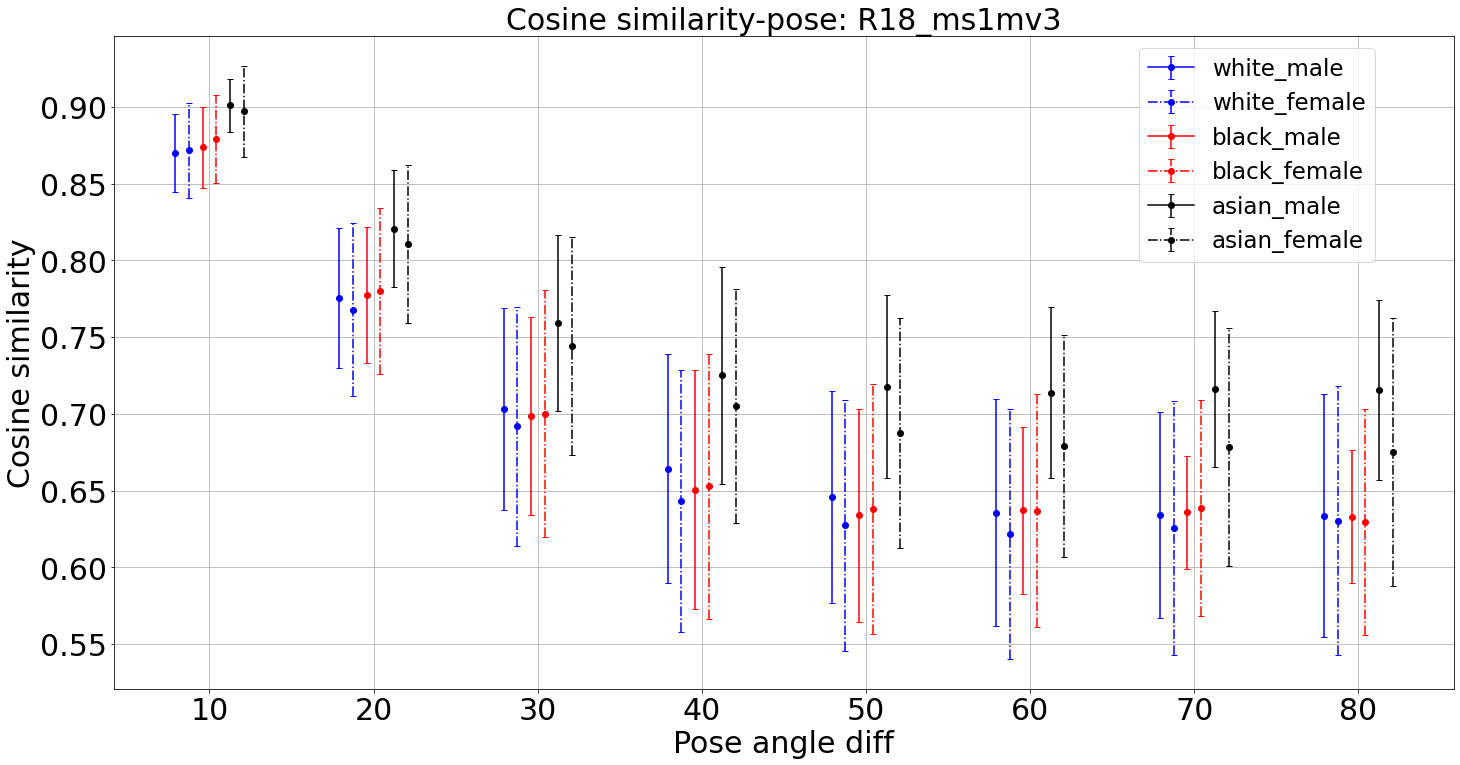

In [374]:
x = range(7)
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(24, 12))
cnt = 1
x_labels = [10, 20, 30, 40, 50, 60, 70, 80]
races = ['white', 'black', 'asian']
genders = ['male','female']
x_range = [i for i in range(1, 9)]
fmts = ['-', '-.']
for j in range(3):
    for k in range(2):
        curr_data = []
        for i in range(1, 9):
            curr_data.append(dist_dict[f'{races[j]}_{genders[k]}'][i])
        
        for p in range(8):
            if p == 0:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/12, np.mean(curr_data[p]), np.std(curr_data[p]),
                             label =f'{races[j]}_{genders[k]}', 
                             color=colors[j],
                             ls=fmts[k],
                             capsize=3,
                             fmt='o')
                eb2[-1][0].set_linestyle(fmts[k])
            else:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/12, np.mean(curr_data[p]), np.std(curr_data[p]),
                             color=colors[j],
                             capsize=3,
                             fmt='o')
                eb2[-1][0].set_linestyle(fmts[k])
# plt.ylim(0.5, 1)
plt.ylabel('Cosine similarity', fontsize=30)
plt.xlabel('Pose angle diff', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(x_range, x_labels, fontsize=30)
plt.title('Cosine similarity-pose: R18_ms1mv3', fontsize=30)
plt.legend(fontsize=23, bbox_to_anchor=(0.95,1))
plt.grid()
plt.savefig("plots/race_gender_pose_r18_ms1mv3_errorbar.jpg")
plt.show()


# Sign-reserved plots

In [416]:
weight = '/scratch/hl106/pretrained_models/face_reco_models/R18_MS1MV3.pth'
net = iresnet18(fp16=False)
net.load_state_dict(torch.load(weight))
net.eval()
net = net.cuda()

In [417]:
angles = [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
dist_dict = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        dist_dict[f'{race}_{gender}'] = {i:[] for i in range(9)}
        for seed in [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]:
            for i in range(9):
                dists = []
                for j in range(9):
                    feat1 = img2feat(net, f'out/picked_3/seed_{seed}/{race}_{gender}_y_{angles[i]}.png')
                    feat2 = img2feat(net, f'out/picked_3/seed_{seed}/{race}_{gender}_y_{angles[j]}.png')
                    dists.append(np.dot(feat1, feat2))
                dist_dict[f'{race}_{gender}'][i].append(dists)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.26s/it]


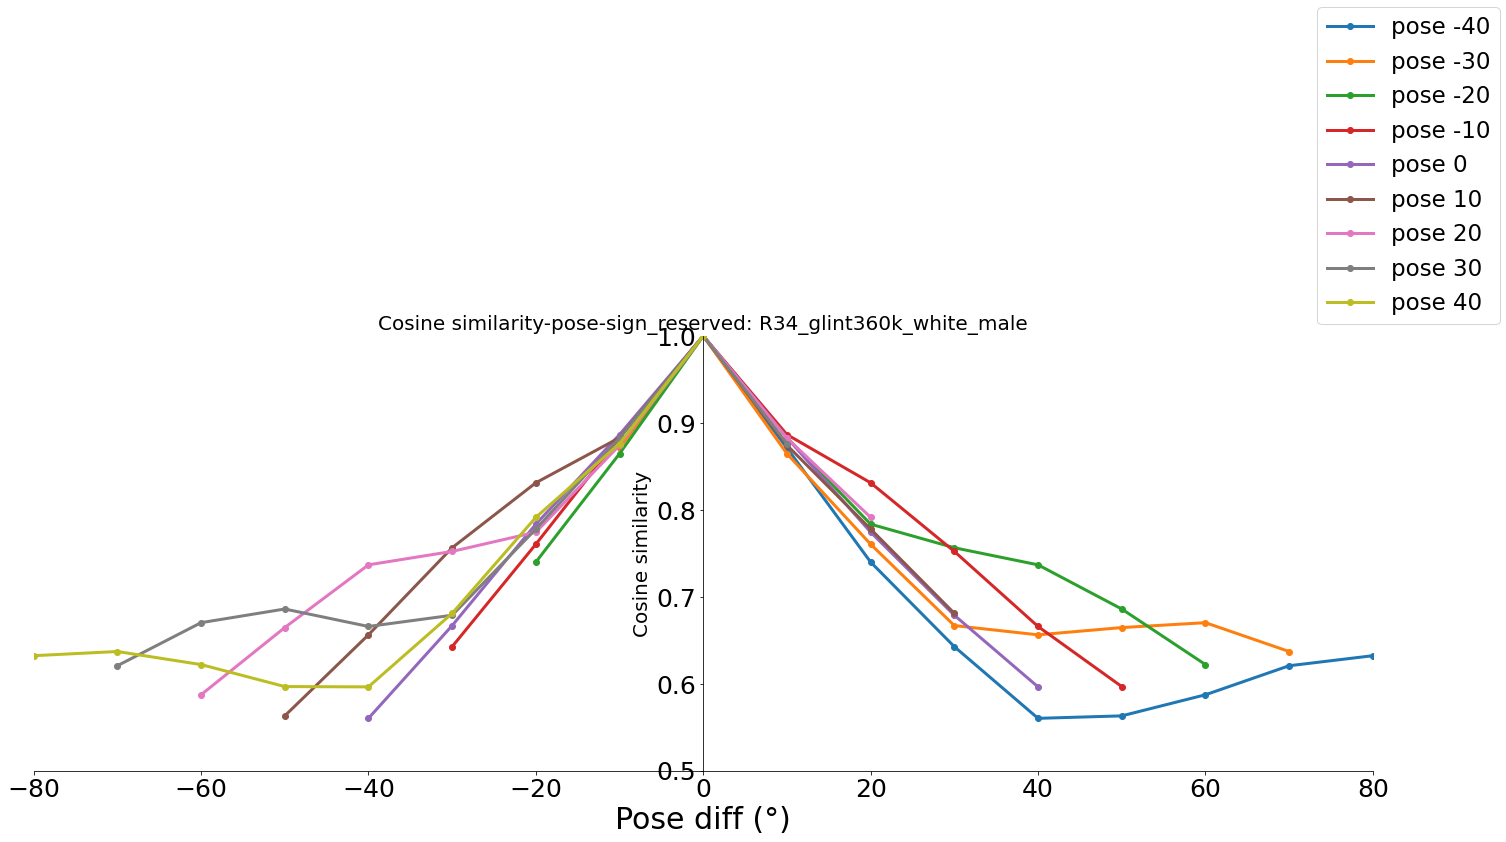

In [409]:
# set width of bar
barWidth = 0.10
# fig = plt.subplots(figsize =(12, 8))
# fig, ax = plt.subplots(3, 3, figsize=(5.6*9, 4.2*9))
# colors = ['#be254a', '#dc484c', '#ef6645', '#f88c51', '#fdb365', '#fed27f', '#feeb9d', '#fffebe', 
# '#f0f9a7', '#d8ef9b', '#b3e0a2', '#89d0a4', '#60bba8', '#3f97b7', '#4273b3']
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

cnt = 1
x_labels = [-80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80]
x_range = [i-8 for i in range(17)]
# ax.set_xticklabels(x_labels, fontsize=30, minor=False)
# ax.plot(x_labels, [0.4]*17)
for race in ['white']:
    for gender in ['male']:
        for i in range(9):
            cd = np.array(dist_dict[f'{race}_{gender}'][i])
            curr_range = x_labels[8-i:17-i]
            if gender == 'male':
                ax.plot(curr_range, np.mean(cd, axis=0), '-o', label =f'pose {x_labels[i+4]}', linewidth=3,)
            else:
                ax.plot(curr_range, np.mean(cd, axis=0), '-o', label =f'{race}_{gender}', linewidth=3, linestyle='dashed')
        
        cnt+=1
        
# ax.set_ylim(0, 1) 
# ax.ylabel('Cosine similarity', fontsize=30)
# ax.xlabel('Pose angle diff', fontsize=30)
# ax.set_yticks(fontsize=30)
# ax.xticks(x_range, x_labels, fontsize=30)
# ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_title('Cosine similarity-pose-sign_reserved: R34_glint360k_white_male', fontsize=20)
ax.set_xlabel('Pose diff (°)', fontsize=30)
ax.set_ylabel('Cosine similarity', fontsize=20)
ax.legend(fontsize=23, bbox_to_anchor=(0.95,1))
# ax.grid()

plt.savefig("plots/sign_reserved/race_gender_pose_r34_glint360k_white_male.jpg")
ax.axis(ymin=0.5,ymax=1)
ax.axis(xmin=-80,xmax=80)
plt.show()

In [418]:
corr = np.zeros((9,9))
cd = dist_dict[f'white_male']
for i in range(9):
    corr[i,:] = np.mean(cd[i], axis=0)

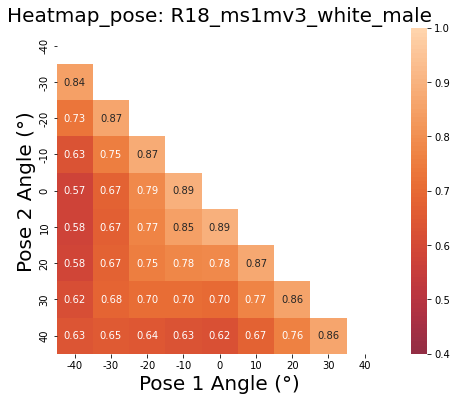

In [419]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 6))
x_axis_labels = [-40, -30, -20, -10, 0, 10, 20, 30, 40]
ax=sns.heatmap(corr, center=0, annot=True, vmax=1, vmin=0.4, mask=mask,
            fmt='.2f', square=True, xticklabels=x_axis_labels, yticklabels=x_axis_labels)
ax.set_xlabel('Pose 1 Angle (°)', fontsize=20)
ax.set_ylabel('Pose 2 Angle (°)', fontsize=20)
ax.set_title('Heatmap_pose: R18_ms1mv3_white_male', fontsize=20)
plt.savefig("plots/sign_reserved/race_gender_pose_r18_ms1mv3_white_male_heatmap.jpg")
plt.show()

# Same seed, different race+gender

In [753]:
weight = '/scratch/hl106/pretrained_models/face_reco_models/R34_Glint360k.pth'
net = iresnet34(fp16=False)
net.load_state_dict(torch.load(weight))
net.eval()
net = net.cuda()

In [189]:
pairs = ['white_male', 'white_female', 'black_male', 'black_female', 'asian_male', 'asian_female', ]
dist_dict = {i:[] for i in pairs}
races = [
    ['white', 'male', 'black', 'female'],
    ['white', 'male', 'asian', 'female'],
    ['white', 'female', 'asian', 'male'],
    ['white', 'female', 'black', 'male'],
    
    ['black', 'male', 'asian', 'female'],
    ['black', 'male', 'white', 'female'],
    ['black', 'female', 'asian', 'male'],
    ['black', 'female', 'white', 'male'],
    
    ['asian', 'male', 'white', 'female'],
    ['asian', 'male', 'white', 'female'],
    ['asian', 'female', 'black', 'male'],
    ['asian', 'female', 'black', 'male'],
    
]
for seed in target_seeds:
    for i in range(6):
        for j in range(2*i, 2*i+2):
            dists = []
            for pose in [-3.0, -1.5, 0.0, 1.5, 3.0]:
                feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed}/{races[j][0]}_{races[j][1]}_y_{0.0}_o2_rm_bg.png')
                feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed}/{races[j][2]}_{races[j][3]}_y_{pose}_o2_rm_bg.png')
                dists.append(np.dot(feat1, feat2))
            dist_dict[pairs[i]].append(dists)

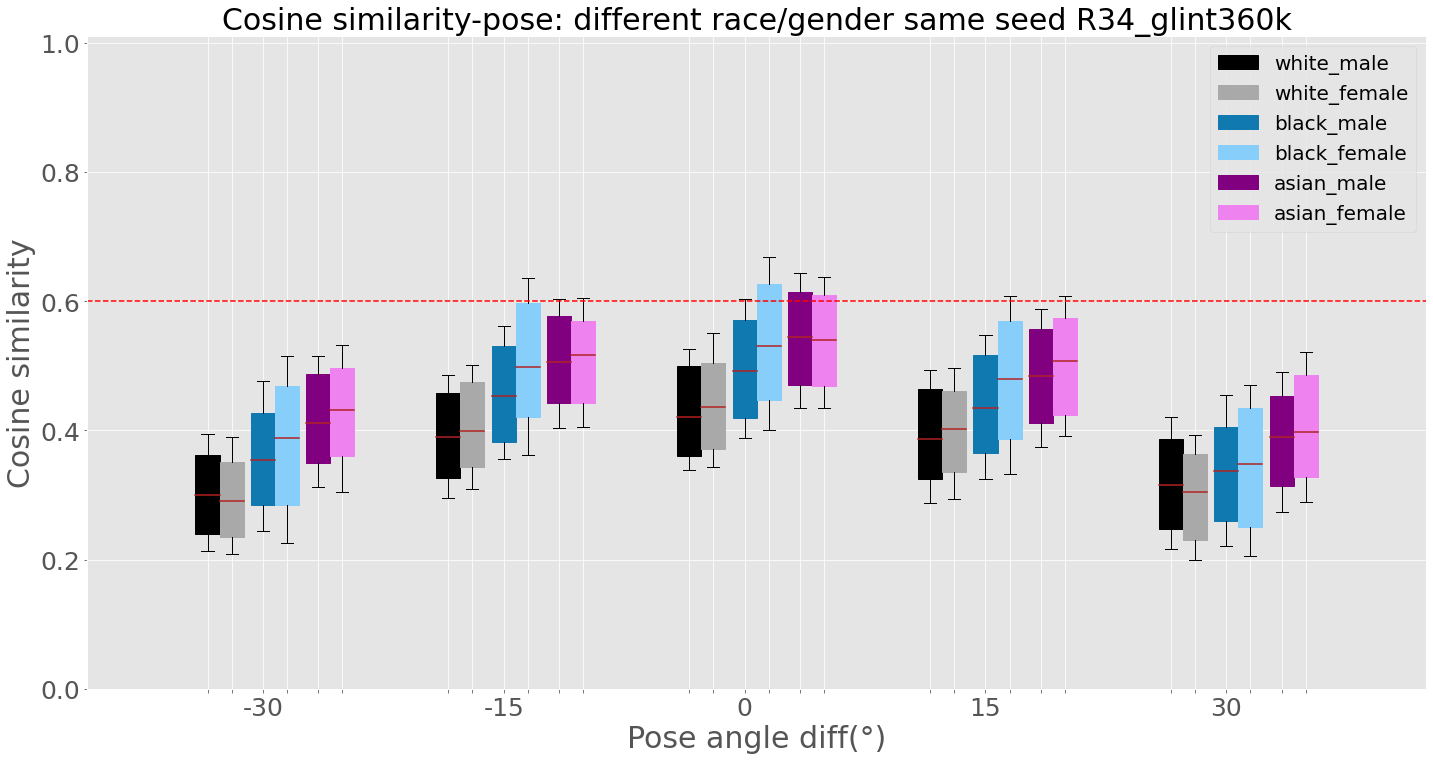

In [274]:
colors = ['black', 'darkgrey', 'xkcd:nice blue', 'lightskyblue', 'purple', 'violet']
fig4, ax4 = plt.subplots(figsize=(24,12))
ax4.set_title('Cosine similarity-pose: different race/gender same seed R34_glint360k', fontsize=30)
angles = [-30, -15, 0, 15, 30]
non_angles = ['']*5
boxes = []
for i in range(6):
    for j in range(5):
        curr_data = dist_dict[pairs[i]][j]
    if i == 2:
        box1 = ax4.boxplot(np.array(dist_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)],
                    widths=0.1, 
                    labels=angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )

    else:
         box1 = ax4.boxplot(np.array(dist_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)], 
                    widths=0.1,
                    labels=non_angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )
    boxes.append(box1)

for i in range(6): 
    ax4.legend([boxes[i]["boxes"][0] for i in range(6)], [pairs[i] for i in range(6)], loc='upper right', fontsize=20)
    
ax4.set_ylim(0,1.01)
# ax4.grid()
ax4.axhline(y=0.6, color='red', linestyle='--')
ax4.tick_params(axis='x', labelsize=25, fontweight='bold')
ax4.tick_params(axis='y', labelsize=25, fontweight='bold') 
ax4.set_xlabel('Pose angle diff(°)', fontsize=30, fontweight='bold')
ax4.set_ylabel('Cosine similarity', fontsize=30, fontweight='bold')
plt.savefig("final_plots/pose/same_seed_diff_race_gender_cos_similarity_pose_r34_glint360k_15_85_ci.jpg")
# plt.grid()
# ax4.set_xticks(fontsize=30)

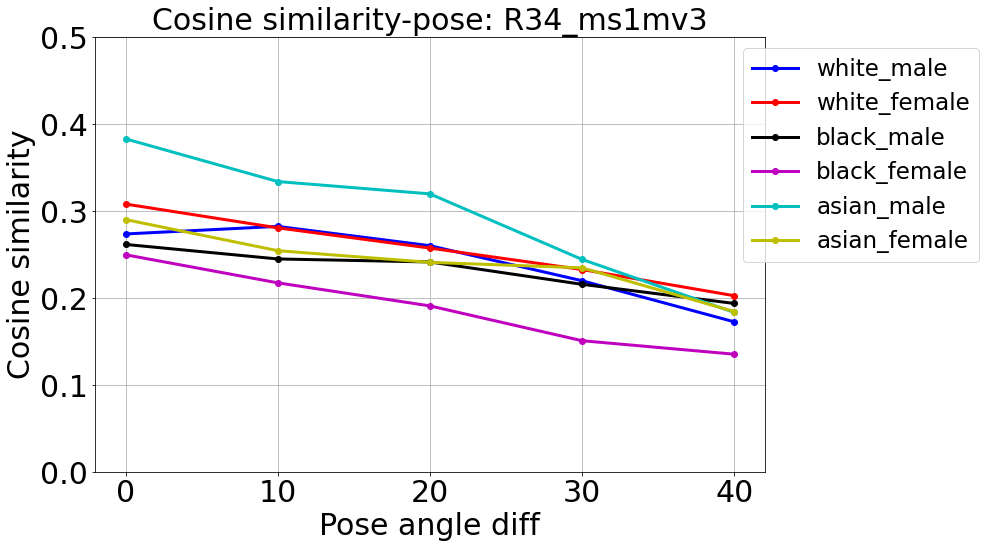

In [536]:
# set width of bar
barWidth = 0.10
# fig = plt.subplots(figsize =(12, 8))
# fig, ax = plt.subplots(3, 3, figsize=(5.6*9, 4.2*9))
# colors = ['#be254a', '#dc484c', '#ef6645', '#f88c51', '#fdb365', '#fed27f', '#feeb9d', '#fffebe', 
# '#f0f9a7', '#d8ef9b', '#b3e0a2', '#89d0a4', '#60bba8', '#3f97b7', '#4273b3']
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(12, 8))
x_labels = [0, 10, 20, 30, 40]
x_range = [i for i in range(5)]

for i in range(6):
    curr_data = []
    cd = np.array(dist_dict[pairs[i]])
    for j in range(5):
        curr_data.append(np.mean(cd[:,j]))
    plt.plot( x_range, curr_data, '-o', label = pairs[i], linewidth=3, color=colors[i])

        
plt.ylim(0, 0.5) 
plt.ylabel('Cosine similarity', fontsize=30)
plt.xlabel('Pose angle diff', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(x_range, x_labels, fontsize=30)
plt.title('Cosine similarity-pose: R34_ms1mv3', fontsize=30)
plt.legend(fontsize=23, bbox_to_anchor=(0.95,1))
plt.grid()
# plt.savefig("plots/same_seed_diff_race_gender/cos_similarity_pose_r34_glint360k.jpg")
# 
plt.show()

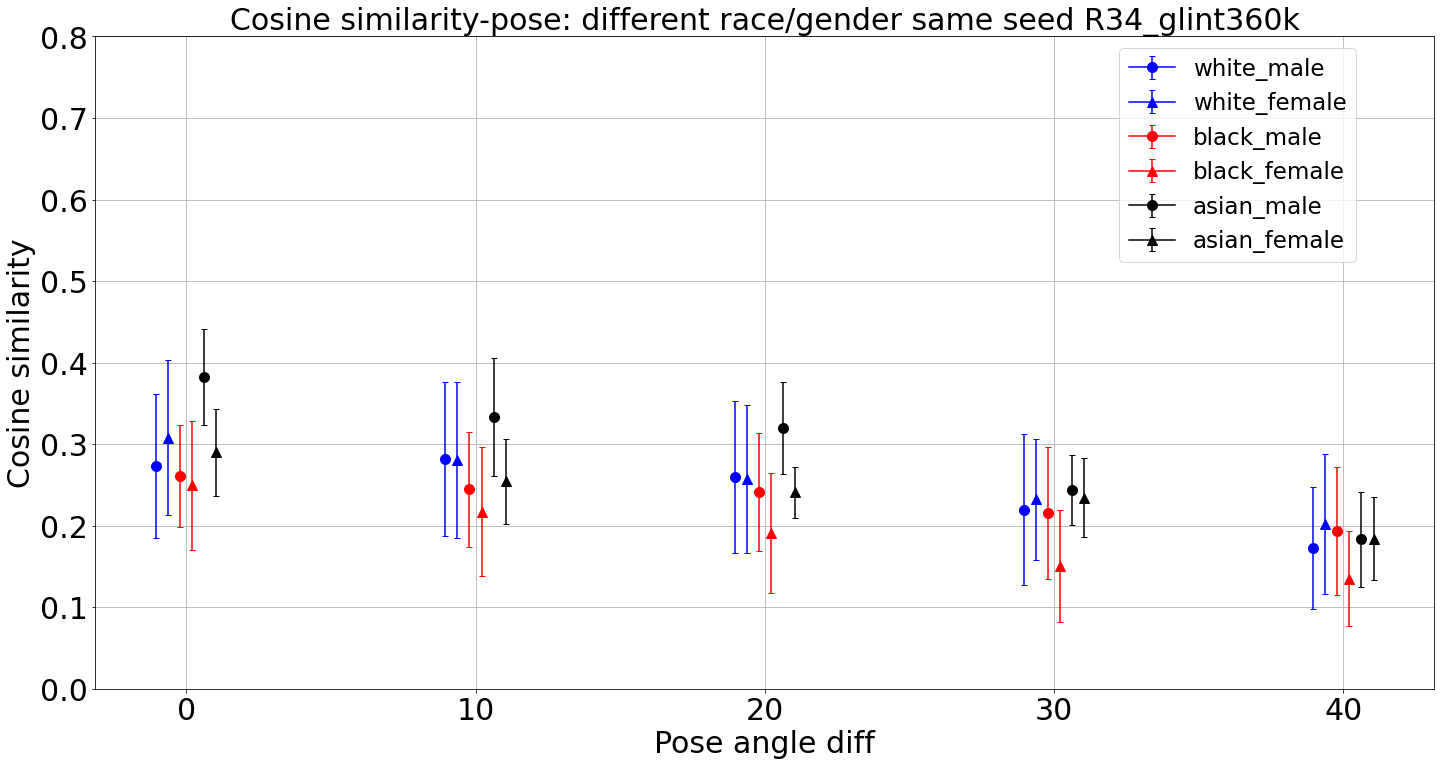

In [543]:
x = range(7)
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(24, 12))
cnt = 1
x_labels = [0, 10, 20, 30, 40]
fmts = ['o', '^', '*', '>']
x_range = [i for i in range(5)]
for j in range(3):
    for k in range(2):
        curr_data = []
        cd = np.array(dist_dict[pairs[2*j+k]])
        for i in range(5):
            curr_data.append(cd[:,i])
        for p in range(5):
            if p == 0:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/24, np.mean(curr_data[p]), np.std(curr_data[p]),
                             label = pairs[2*j+k], 
                             color=colors[j],
                             capsize=3,
                             marker=fmts[k],
                             markersize='10',
                                )


            else:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/24, np.mean(curr_data[p]), np.std(curr_data[p]),
                             color=colors[j],
                             capsize=3,
                             marker=fmts[k],
                             markersize='10')

plt.ylim(0, 0.8)
plt.ylabel('Cosine similarity', fontsize=30)
plt.xlabel('Pose angle diff', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(x_range, x_labels, fontsize=30)
plt.title('Cosine similarity-pose: different race/gender same seed R34_glint360k', fontsize=30)
plt.legend(fontsize=23, bbox_to_anchor=(0.95,1))
plt.grid()
plt.savefig("plots/same_seed_diff_race_gender/cos_similarity_pose_r34_glint360k_errorbar.jpg")
plt.show()

# Different seed, same race+gender

In [381]:
dist_dict = {}
# seeds = [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]
attr = [-3.0,-1.5,0.0,1.5,3.0]
attr_pairs = [[2,0], [2,1], [2,2], [2,3], [2,4]]
np.random.seed(3)

for race in ['white', 'black', 'asian']:
    for gender in ['male', 'female']:
        dist_dict[f'{race}_{gender}'] = []
        for seed1 in target_seeds:
            tmp = target_seeds.copy()
            tmp.remove(seed1)
            choice = np.random.choice(tmp, size=3, replace=False)
            for j in range(3):
                seed2 = choice[j]
                dists = []
                for p in age_pairs:
                    feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed1}/{race}_{gender}_y_{attr[p[0]]}_o2_rm_bg.png')
                    feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed2}/{race}_{gender}_y_{attr[p[1]]}_o2_rm_bg.png')
                    dists.append(np.dot(feat1, feat2))
                dist_dict[f'{race}_{gender}'].append(dists)

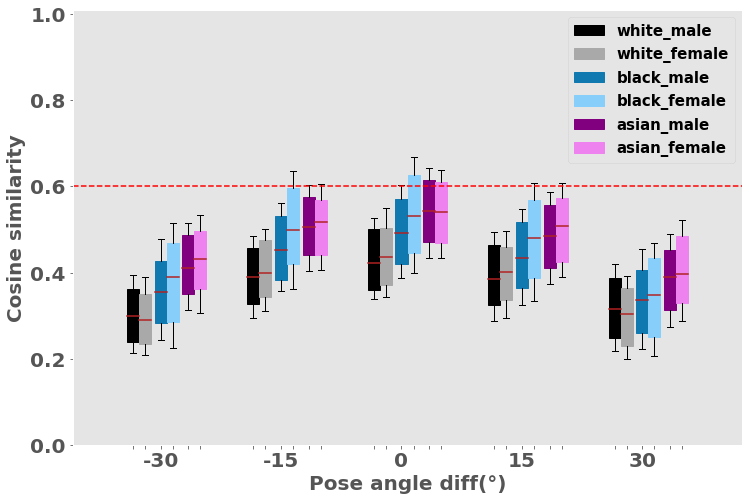

In [384]:
colors = ['black', 'darkgrey', 'xkcd:nice blue', 'lightskyblue', 'purple', 'violet']
fig4, ax4 = plt.subplots(figsize=(12, 8))
# ax4.set_title('Cosine similarity-pose: same race/gender different seed R34_glint360k', fontsize=30)
angles = [-30, -15, 0, 15, 30]
non_angles = ['']*5
boxes = []
for i in range(6):
#     curr_data = np.zeros((100,5))
    for j in range(5):
        curr_data = dist_dict[pairs[i]][j]
    if i == 2:
        box1 = ax4.boxplot(np.array(dist_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)],
                    widths=0.1, 
                    labels=angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )

    else:
         box1 = ax4.boxplot(np.array(dist_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)],
                    widths=0.1,
                    labels=non_angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )
    boxes.append(box1)

legend_properties = {'weight':'bold', 'size':15}
for i in range(6): 
    ax4.legend([boxes[i]["boxes"][0] for i in range(6)], [pairs[i] for i in range(6)], loc='upper right', prop=legend_properties)

# ax4.set_facecolor("gai")
ax4.set_ylim(0,1.01)
ax4.grid()
ax4.axhline(y=0.6, color='red', linestyle='--')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
ax4.set_xlabel('Pose angle diff(°)', fontsize=20, fontweight='bold')
ax4.set_ylabel('Cosine similarity', fontsize=20, fontweight='bold')
plt.savefig("final_plots/pose/diff_seed_same_race_gender_cos_similarity_pose_r34_glint360k_15_85_ci.jpg", bbox_inches = "tight")
# plt.grid()
# ax4.set_xticks(fontsize=30)

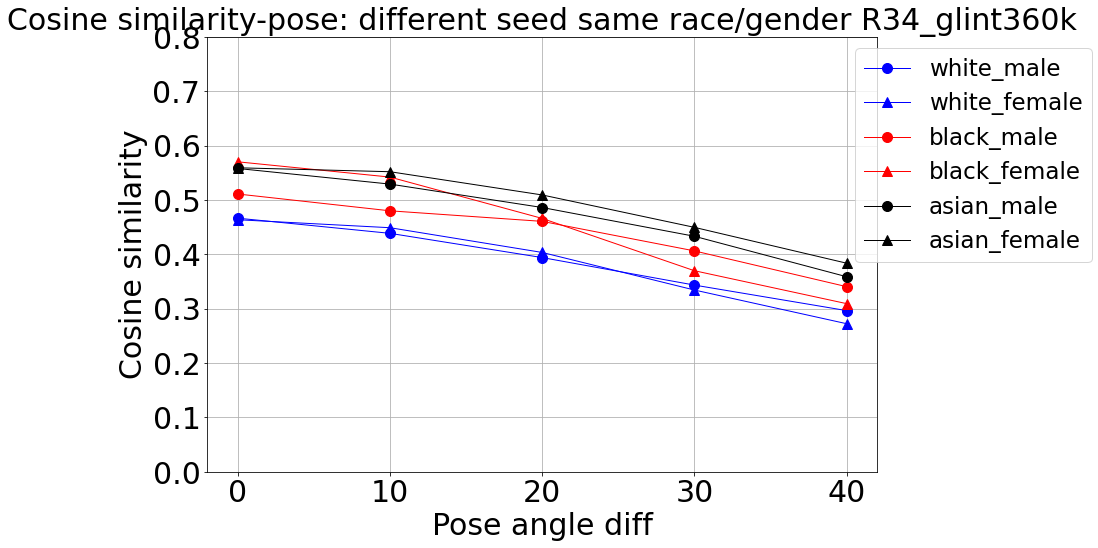

In [524]:
# set width of bar
barWidth = 0.10
# fig = plt.subplots(figsize =(12, 8))
# fig, ax = plt.subplots(3, 3, figsize=(5.6*9, 4.2*9))
# colors = ['#be254a', '#dc484c', '#ef6645', '#f88c51', '#fdb365', '#fed27f', '#feeb9d', '#fffebe', 
# '#f0f9a7', '#d8ef9b', '#b3e0a2', '#89d0a4', '#60bba8', '#3f97b7', '#4273b3']
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(12, 8))
cnt = 1
x_labels = [0, 10, 20, 30, 40]
x_range = [i for i in range(5)]

for race in ['white', 'black', 'asian']:
    for gender in ['male', 'female']:
        curr_data = []
        cd = np.array(dist_dict[f'{race}_{gender}'])
        for i in range(5):
            curr_data.append(np.mean(cd[:, i]))
        
        if gender == 'male':
            plt.plot( x_range, curr_data, '-o', label =f'{race}_{gender}', linewidth=1, color=colors[(cnt-1)//2], markersize='10')
        else:
            plt.plot( x_range, curr_data, '-^', label =f'{race}_{gender}', linewidth=1, color=colors[(cnt-1)//2], markersize='10')
        
        cnt+=1
        
plt.ylim(0, 0.8) 
plt.ylabel('Cosine similarity', fontsize=30)
plt.xlabel('Pose angle diff', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(x_range, x_labels, fontsize=30)
plt.title('Cosine similarity-pose: different seed same race/gender R34_glint360k', fontsize=30)
plt.legend(fontsize=23, bbox_to_anchor=(0.95,1))
plt.grid()
plt.savefig("plots/diff_seed_same_race_gender/race_gender_pose_r34_glint360k.jpg")
# 
plt.show()

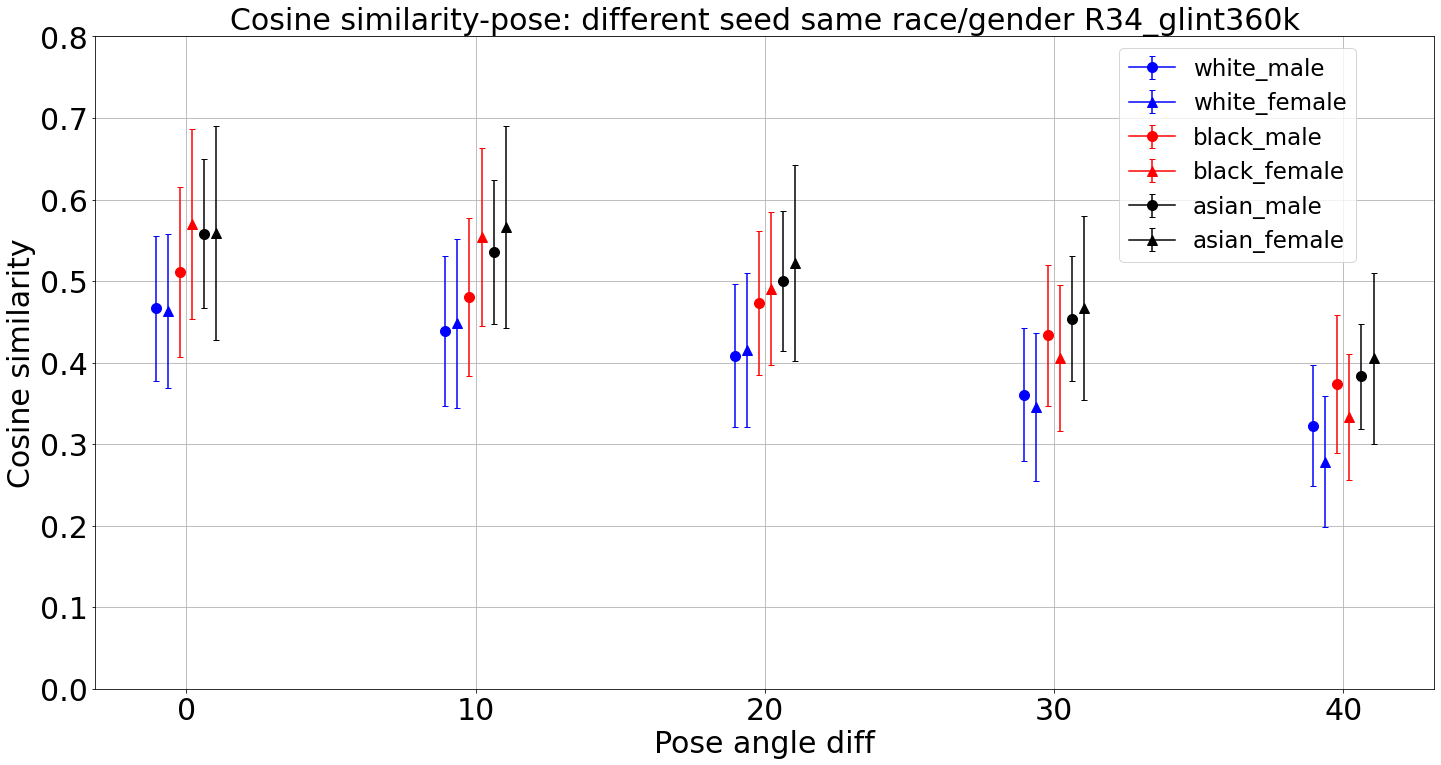

In [558]:
x = range(7)
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(24, 12))
cnt = 1
x_labels = [0, 10, 20, 30, 40]
races = ['white', 'black', 'asian']
genders = ['male','female']
x_range = [i for i in range(5)]
fmts = ['o', '^', '*', '>']
for j in range(3):
    for k in range(2):
        curr_data = []
        cd = np.array(dist_dict[f'{races[j]}_{genders[k]}'])
        for i in range(5):
            curr_data.append(cd[:, i])
        
        for p in range(5):
            if p == 0:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/24, np.mean(curr_data[p]), np.std(curr_data[p]),
                             label =f'{races[j]}_{genders[k]}', 
                             color=colors[j],
                             capsize=3,
                             marker=fmts[k],
                             markersize='10',
#                              fmt=fmts[k]
                                )
#                 eb2[-1][0].set_linestyle(fmts[k])
            else:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/24, np.mean(curr_data[p]), np.std(curr_data[p]),
                             color=colors[j],
                             capsize=3,
                             marker=fmts[k],
                             markersize='10',
#                              fmt='o'
                                )
#                 eb2[-1][0].set_linestyle(fmts[k])
plt.ylim(0, 0.8)
plt.ylabel('Cosine similarity', fontsize=30)
plt.xlabel('Pose angle diff', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(x_range, x_labels, fontsize=30)
plt.title('Cosine similarity-pose: different seed same race/gender R34_glint360k', fontsize=30)
plt.legend(fontsize=23, bbox_to_anchor=(0.95,1))
plt.grid()
plt.savefig("plots/diff_seed_same_race_gender/race_gender_pose_r34_glint360k_errorbar.jpg")
plt.show()

# Different race, different seed

In [ ]:
pairs = ['white_male', 'white_female', 'black_male', 'black_female', 'asian_male', 'asian_female', ]
dist_dict = {i:[] for i in pairs}
races = [
    ['white', 'male', 'black', 'female'],
    ['white', 'male', 'asian', 'female'],
    ['white', 'female', 'asian', 'male'],
    ['white', 'female', 'black', 'male'],
    
    ['black', 'male', 'asian', 'female'],
    ['black', 'male', 'white', 'female'],
    ['black', 'female', 'asian', 'male'],
    ['black', 'female', 'white', 'male'],
    
    ['asian', 'male', 'white', 'female'],
    ['asian', 'male', 'white', 'female'],
    ['asian', 'female', 'black', 'male'],
    ['asian', 'female', 'black', 'male'],
    
]
np.random.seed(3)
# seeds = [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]
for i in range(6):
    for j in range(2*i, 2*i+2):
        for seed1 in target_seeds:
            tmp = target_seeds.copy()
            tmp.remove(seed1)
            choice = np.random.choice(tmp, size=3, replace=False)
            for j in range(3):
                seed2 = choice[j]
                dists = []
                for pose in [-3.0, -1.5, 0.0, 1.5, 3.0]:
                    feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed1}/{races[j][0]}_{races[j][1]}_y_{0.0}_o2_rm_bg.png')
                    feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed2}/{races[j][2]}_{races[j][3]}_y_{pose}_o2_rm_bg.png')
                    dists.append(np.dot(feat1, feat2))
                dist_dict[pairs[i]].append(dists)

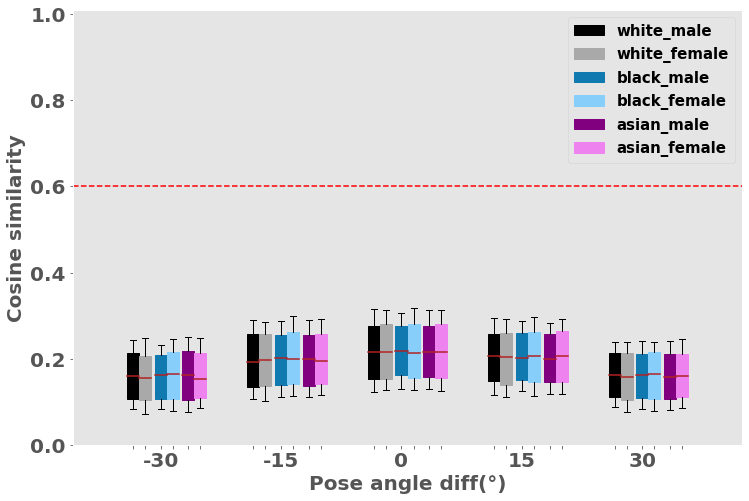

In [390]:
colors = ['black', 'darkgrey', 'xkcd:nice blue', 'lightskyblue', 'purple', 'violet']
fig4, ax4 = plt.subplots(figsize=(12, 8))
# ax4.set_title('Cosine similarity-pose: different race/gender different seed R34_glint360k', fontsize=30)
angles = [-30, -15, 0, 15, 30]
non_angles = ['']*5
boxes = []
for i in range(6):
    if i == 2:
        box1 = ax4.boxplot(np.array(dist_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)],
                    widths=0.1, 
                    labels=angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )

    else:
         box1 = ax4.boxplot(np.array(dist_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)], 
                    widths=0.1,
                    labels=non_angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )
    boxes.append(box1)
legend_properties = {'weight':'bold', 'size':15}
for i in range(6): 
    ax4.legend([boxes[i]["boxes"][0] for i in range(6)], [pairs[i] for i in range(6)], loc='upper right', prop=legend_properties)  
ax4.set_ylim(0,1.01)
ax4.grid()
ax4.axhline(y=0.6, color='red', linestyle='--')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
ax4.set_xlabel('Pose angle diff(°)', fontsize=20, fontweight='bold')
ax4.set_ylabel('Cosine similarity', fontsize=20, fontweight='bold')
plt.savefig("final_plots/pose/diff_seed_diff_race_gender_cos_similarity_pose_r34_glint360k_15_85_ci.jpg", bbox_inches = "tight")
# plt.grid()
# ax4.set_xticks(fontsize=30)

# different seed any race/gender

In [590]:
dist_dict = {}
seeds = [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]
for race in ['white', 'black', 'asian']:
    for gender in ['male', 'female']:
        dist_dict[f'{race}_{gender}'] = []
        for seed1 in range(len(seeds)):
            for seed2 in range(seed1+1, len(seeds)):
                for race2 in ['white', 'black', 'asian']:
                    for gender2 in ['male', 'female']:
                        dists = []
                        for pose in [0.0]:
                            feat1 = img2feat(net, f'out/picked_3/seed_{seeds[seed1]}/{race}_{gender}_y_{0.0}.png')
                            feat2 = img2feat(net, f'out/picked_3/seed_{seeds[seed2]}/{race2}_{gender2}_y_{pose}.png')
                            dists.append(np.dot(feat1, feat2))
                        dist_dict[f'{race}_{gender}'].append(dists)

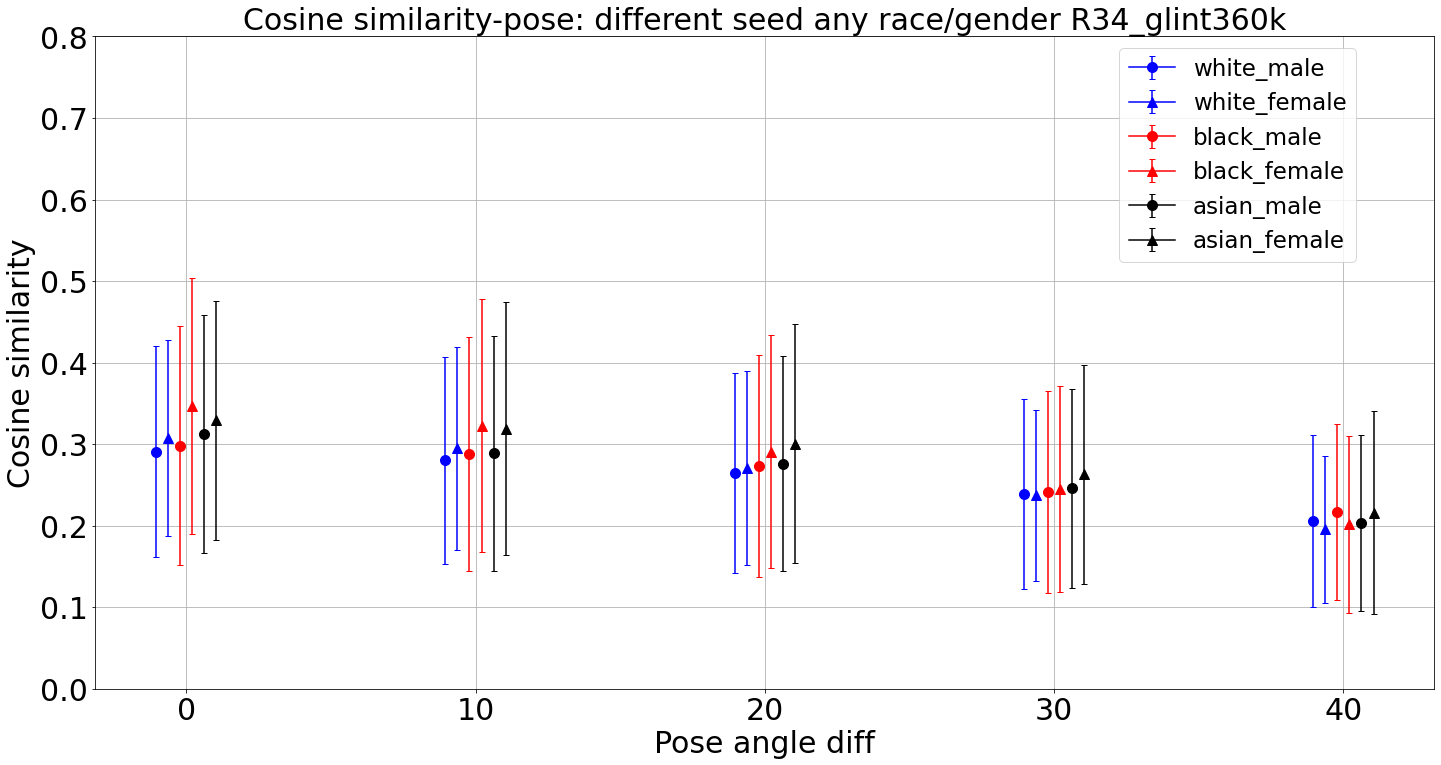

In [562]:
x = range(7)
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(24, 12))
cnt = 1
x_labels = [0, 10, 20, 30, 40]
races = ['white', 'black', 'asian']
genders = ['male','female']
x_range = [i for i in range(5)]
fmts = ['o', '^', '*', '>']
for j in range(3):
    for k in range(2):
        curr_data = []
        cd = np.array(dist_dict[f'{races[j]}_{genders[k]}'])
        for i in range(5):
            curr_data.append(cd[:, i])
        
        for p in range(5):
            if p == 0:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/24, np.mean(curr_data[p]), np.std(curr_data[p]),
                             label =f'{races[j]}_{genders[k]}', 
                             color=colors[j],
                             capsize=3,
                             marker=fmts[k],
                             markersize='10',
#                              fmt=fmts[k]
                                )
#                 eb2[-1][0].set_linestyle(fmts[k])
            else:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/24, np.mean(curr_data[p]), np.std(curr_data[p]),
                             color=colors[j],
                             capsize=3,
                             marker=fmts[k],
                             markersize='10',
#                              fmt='o'
                                )
#                 eb2[-1][0].set_linestyle(fmts[k])
plt.ylim(0, 0.8)
plt.ylabel('Cosine similarity', fontsize=30)
plt.xlabel('Pose angle diff', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(x_range, x_labels, fontsize=30)
plt.title('Cosine similarity-pose: different seed any race/gender R34_glint360k', fontsize=30)
plt.legend(fontsize=23, bbox_to_anchor=(0.95,1))
plt.grid()
plt.savefig("plots/diff_seed_any_race_gender/race_gender_pose_r34_glint360k_errorbar.jpg")
plt.show()

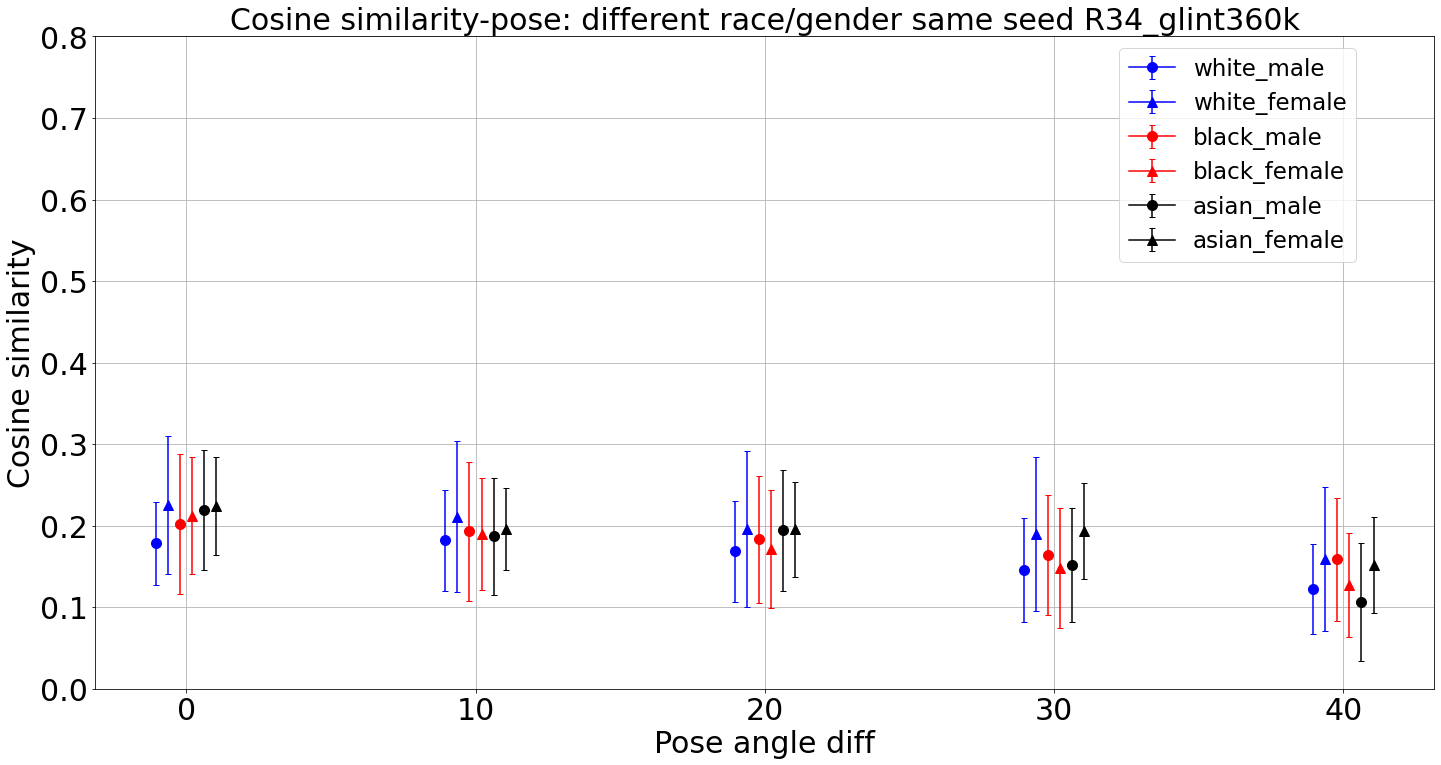

In [601]:
x = range(7)
colors = ['b', 'r', 'k', 'm', 'c', 'y']

fig = plt.figure(figsize=(24, 12))
cnt = 1
x_labels = [0, 10, 20, 30, 40]
fmts = ['o', '^', '*', '>']
x_range = [i for i in range(5)]
for j in range(3):
    for k in range(2):
        curr_data = []
        cd = np.array(dist_dict[pairs[2*j+k]])
        for i in range(5):
            curr_data.append(cd[:,i])
        for p in range(5):
            if p == 0:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/24, np.mean(curr_data[p]), np.std(curr_data[p]),
                             label = pairs[2*j+k], 
                             color=colors[j],
                             capsize=3,
                             marker=fmts[k],
                             markersize='10',
                                )


            else:
                eb2=plt.errorbar(x_range[p]+((2*j+k)-2.5)/24, np.mean(curr_data[p]), np.std(curr_data[p]),
                             color=colors[j],
                             capsize=3,
                             marker=fmts[k],
                             markersize='10')

plt.ylim(0, 0.8)
plt.ylabel('Cosine similarity', fontsize=30)
plt.xlabel('Pose angle diff', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(x_range, x_labels, fontsize=30)
plt.title('Cosine similarity-pose: different race/gender same seed R34_glint360k', fontsize=30)
plt.legend(fontsize=23, bbox_to_anchor=(0.95,1))
plt.grid()
# plt.savefig("plots/diff_seed_diff_race_gender/cos_similarity_pose_r34_glint360k_errorbar.jpg")
plt.show()

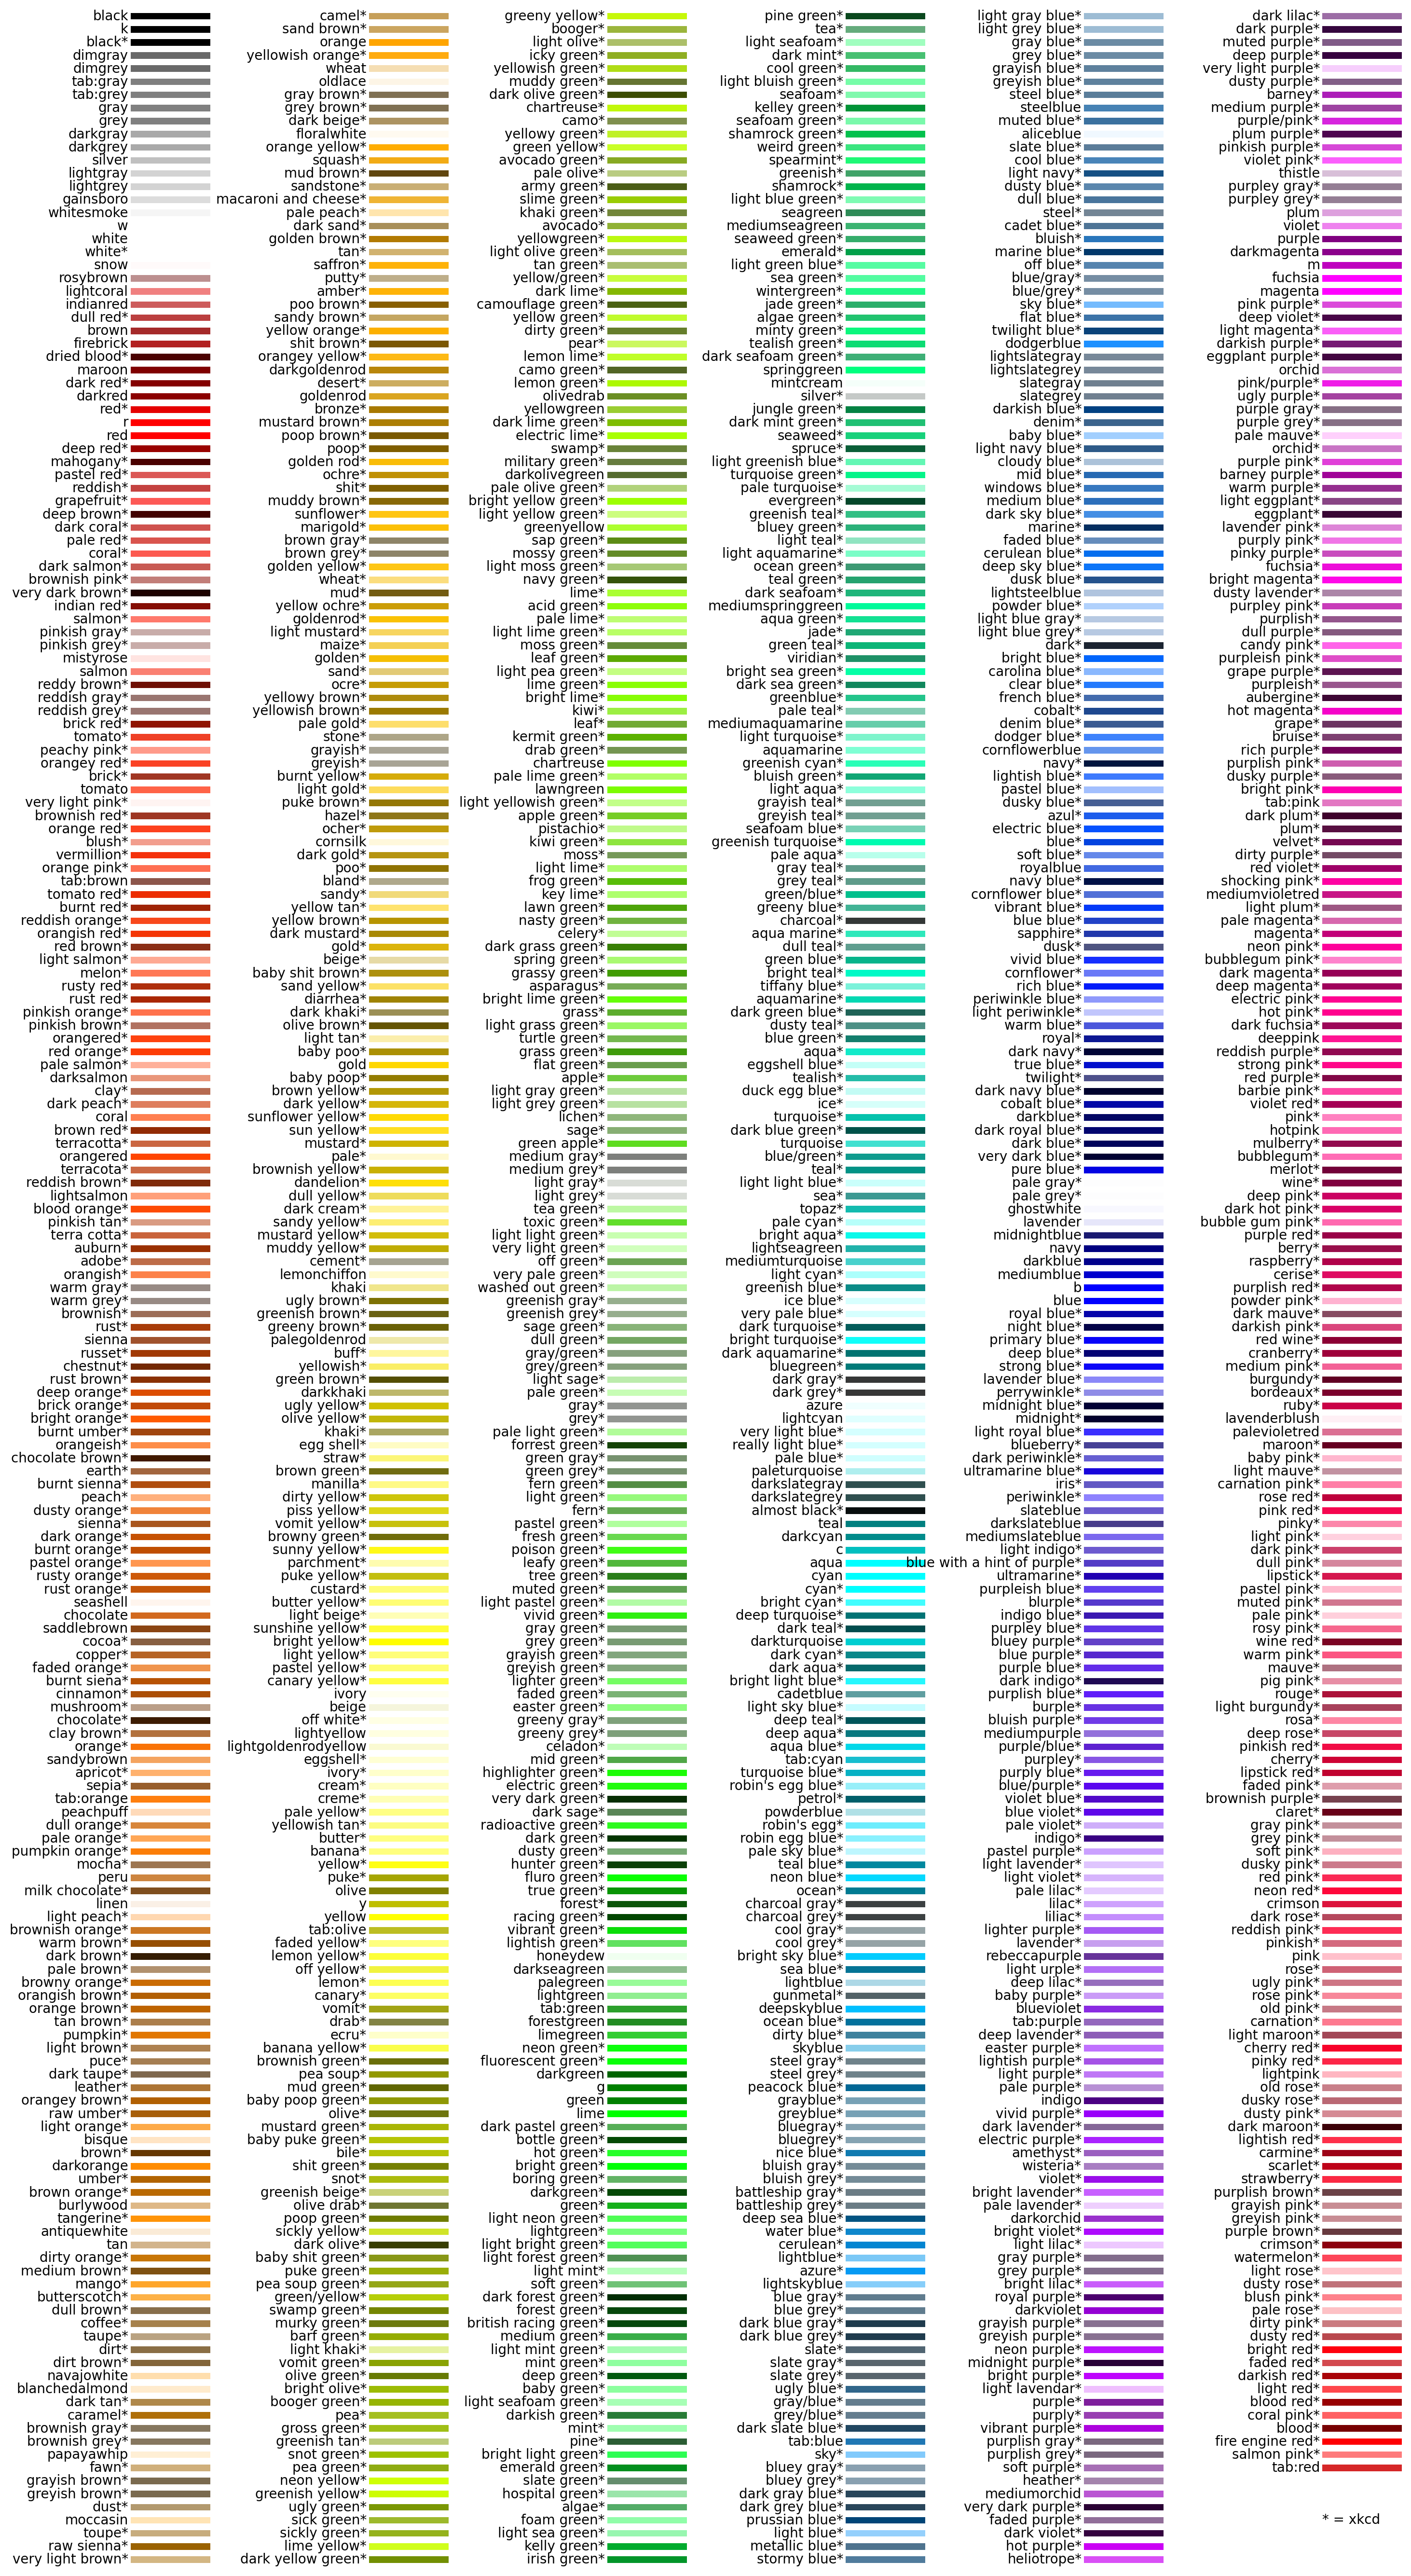

In [716]:
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

colors = mcolors._colors_full_map #dictionary of all colors

#sort them by hsv
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

def plot_all_colors():
    fig = plt.figure(figsize=(17,35),dpi=200)
    grid = GridSpec(195,6,hspace=1,wspace=2)
    counter = 0
    while counter < 1163:
        column = (counter//195)%6
        row = counter%195
        ax = fig.add_subplot(grid[row,column])
        ax.axis('off')
        ax.axhline(0,linewidth=15,c=sorted_names[counter])
        color_str = sorted_names[counter]
        #recall that xkcd colors must be prefaced with "xkdc:". To save space, I'll take that out
        #and replace with an asterisk so we can still identify them
        if 'xkcd' in color_str:
            color_str = color_str[5:]+'*'
        ax.text(-0.03,0.5,color_str,ha='right',va='center')
        counter+=1
    else:
        ax = fig.add_subplot(grid[-4,-1])
        ax.axis('off')
        ax.text(0,0,'* = xkcd')
#         fig.savefig('matplotlib named colors.png', bbox_inches='tight') #uncomment to save figure
            
plot_all_colors()

In [144]:
import utils
import cv2

device = 'cuda'

seg_net = utils.load_face_segmenter(device)
mask_func = utils.mask_by_segmentation(seg_net, device, "not-hair")

def evaluate(image_path='./imgs/116.jpg', cp='models/79999_iter.pth'):
    from bisenet_model import BiSeNet
    # if not os.path.exists(respth):
    #     os.makedirs(respth)

    n_classes = 19
    net = BiSeNet(n_classes=n_classes)
    net.cuda()
    net.load_state_dict(torch.load(cp))
    net.eval()

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    with torch.no_grad():
        img = Image.open(image_path)
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        # print(parsing)
        # print(np.unique(parsing))

        # vis_parsing_maps(image, parsing, stride=1, save_im=False, save_path=osp.join(respth, dspth))
        return parsing

def make_mask(parsing, values):
    mask = np.zeros((512,512))
    for i in range(512):
        for j in range(512):
            if parsing[i,j] in values:
                mask[i,j] = 1 
    return mask

In [4]:
import pickle

with open('picked_seeds.data', 'rb') as filehandle:
    # Read the data as a binary data stream
    target_seeds = pickle.load(filehandle)

# for i in tqdm(target_seeds):
#     for j, race in enumerate(['white', 'black', 'asian']):
#         for k, gender in enumerate(['male', 'female']):
#             for l, a in enumerate([-3.0,-1.5,0.0,1.5,3.0]):
#                 parsing=evaluate(f'out/final_picked_pose/seed_{i}/{race}_{gender}_y_{a}.png')
#                 img = cv2.imread(f'out/final_picked_pose/seed_{i}/{race}_{gender}_y_{a}.png')
#                 mask1 = make_mask(parsing, [i+1 for i in range(13)] + [17])
#                 new_img = img*mask1[..., np.newaxis]
#                 new_img[new_img==0]=255
#                 cv2.imwrite(f'out/final_picked_pose/seed_{i}/{race}_{gender}_y_{a}_o2_rm_bg.png', new_img.astype('int'))

In [154]:
import os
from PIL import Image

os.makedirs(f'/scratch/hl106/eg3d/test_image_pairs', exist_ok=True)
# seeds = [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]
ages = [-3.0,-1.5,0.0,1.5,3.0]
age_pairs = [[2,0], [2,1], [2,3], [2,4]]
for seed in tqdm(target_seeds):
    for race in ['white', 'black', 'asian']:
        for gender in ['male', 'female']:
            for p in age_pairs:
                img1 = Image.open(f'out/final_picked_pose/seed_{seed}/{race}_{gender}_y_{ages[p[0]]}_o2_rm_bg.png').resize((256,256))
                img2 = Image.open(f'out/final_picked_pose/seed_{seed}/{race}_{gender}_y_{ages[p[1]]}_o2_rm_bg.png').resize((256,256))
                
                new_im = Image.new('RGB', (2*256,1*256), (256,256,256))
                new_im.paste(img1, (0*256, 0*256))
                new_im.paste(img2, (1*256, 0*256))
                new_im.save(f'/scratch/hl106/eg3d/test_image_pairs_2/eg3d_{seed}_{race}{gender}_pose_{p[0]}__{seed}_{race}{gender}_pose_{p[1]}.png')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


In [155]:
import numpy as np
ages = [-3.0,-1.5,0.0,1.5,3.0]
age_pairs = [[2,0], [2,1], [2,2], [2,3], [2,4]]
np.random.seed(3)
for race in ['white', 'black', 'asian']:
    for gender in ['male', 'female']:
        for seed1 in target_seeds:
            tmp = target_seeds.copy()
            tmp.remove(seed1)
            choice = np.random.choice(tmp, size=3, replace=False)
            for j in range(3):
                seed2 = choice[j]
                for p in age_pairs:
                    img1 = Image.open(f'out/final_picked_pose/seed_{seed1}/{race}_{gender}_y_{ages[p[0]]}_o2_rm_bg.png').resize((256,256))
                    img2 = Image.open(f'out/final_picked_pose/seed_{seed2}/{race}_{gender}_y_{ages[p[1]]}_o2_rm_bg.png').resize((256,256))

                    new_im = Image.new('RGB', (2*256,1*256), (256,256,256))
                    new_im.paste(img1, (0*256, 0*256))
                    new_im.paste(img2, (1*256, 0*256))
                    new_im.save(f'/scratch/hl106/eg3d/test_image_pairs_2/eg3d_{seed1}_{race}{gender}_pose_{p[0]}__{seed2}_{race}{gender}_pose_{p[1]}.png')

# Human annotation results

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import time
import jsonlines
import scipy as sy
import pickle
#from tqdm import tqdm

class annotationDatabase():
    
    def __init__(self,annotations_file_names, labelScores):
        '''Parameters:
        annotations_file_names - list of names of jupyter files where the annotations are saved.
        Each file refers to one image.'''
        self.annotators = {}           # dictionary that maps the unique ID strings of annotators to local integer IDs
        self.annotator_names = []      # list of the unique string identifiers that AMT uses sorted by integer ID
        self.annotations = []          # list of the number of annotations per annotator
        self.N_ANNOTATORS = len(self.annotators)
        self.N_IMAGES = len(annotations_file_names)
        self.imageScores = []          # scores this image received -- list of lists
        self.imageAnnotators = []      # annotators who worked on a given image -- list of lists
        
        #
        # for each file extract all the useful annotations
        #
        for i, fname in enumerate(annotations_file_names):
            with open(fname, 'r') as read_file:
                data = json.load(read_file)                  # open the json file and read its contents into data
                scores = []                                  # initialize the two lists of scores and IDs for the current image
                annotatorIDs = []
                for a,ans in enumerate(data['answers']):     # read each annotator's annotation
                    ID = self.addAnnotation(ans['workerId']) # mark annotation and retrieve ID of annotator
                    annotatorIDs.append(ID)                  # take note of which annotator it was
                    label = data['answers'][a]['answerContent']['crowd-image-classifier']['label']
                    scores.append(labelScores[label]) # transform label into score
                    
                self.imageScores.append(scores)
                self.imageAnnotators.append(annotatorIDs)
        
        print(f'Found {self.N_IMAGES} images and {self.N_ANNOTATORS} annotators.')
        
    def addAnnotation(self,annotator_name):
        '''Keep track of the annotations and of the annotators'''
        try:
            ID = self.annotators[annotator_name] # the annotator was found, here is her ID
            self.annotations[ID] += 1 # chalk up one more annotation for this annotator
        except: # the annotator was not on the list
            ID = self.N_ANNOTATORS # create a new ID
            self.annotators[annotator_name] = ID
            self.N_ANNOTATORS +=1
            self.annotations.append(1) # add a count of one for the last annotator
            self.annotator_names.append(annotator_name)
        return ID
    
    def annotatorID(self,annotator_name):
        '''Retrieve the integer ID of an annotator from his/her name string'''
        try:
            ID = self.annotators[annotator_name] # the annotator was found, here is her ID
        except: # the annotator was not on the list
            ID = -1
            print(f'Annotator {annotator_name} not found in annotator directory. Something is wrong.')
        return ID
    
def extract_ID_gender_race(name):
    l = name.split('_')
    id1 = l[1]
    gr1 = l[2]
    task = l[3]
    attr1 = l[4]
    
    id2 = l[6]
    gr2 = l[7]
    attr2 = l[9][0]
    return (id1,gr1,attr1,id2,gr2,attr2, task)

def get_mid_5_scores(scores):
    return np.sort(scores)[2:-2]

In [8]:
ANNOTATIONS_PATH = '2022-10-26-Synthetic-Face-Pairs-50K-Hao/perona-same-or-different-000/annotations/worker-response'
LABELS_PATH = '2022-10-26-Synthetic-Face-Pairs-50K-Hao/perona-same-or-different-000/annotation-tool/data.json'
OUT_MANIFEST_PATH = '2022-10-26-Synthetic-Face-Pairs-50K-Hao/perona-same-or-different-000/manifests/output/output.manifest'

In [10]:
#Read labels using annotation-tool/data.json and assign integers to labels 
with open(LABELS_PATH, 'r') as labels_file:
    labels_data = json.load(labels_file)['labels']
    labels = [l['label'] for l in labels_data]
labelScores = {l:i for (i, l) in enumerate(labels)} # generate numerical scores for the labels - useful in regression

print(labels)
print(labelScores)

# Make map from annotation index to image index
idx_map = [] # list of image names in order of their annotation number
with jsonlines.open(OUT_MANIFEST_PATH) as reader:
    for obj in reader:
        _, name = os.path.split(obj['source-ref']) #remove leading path
        idx = name #name.split('.')[0]
        idx_map.append(idx)

annotation_file_names = []
for i in range(len(idx_map)):
    annotation_file_names += glob.glob(ANNOTATIONS_PATH + '/*/%d/*.json'% i) 
        

annotations = annotationDatabase(annotation_file_names, labelScores)
scores = np.array(annotations.imageScores)
    
print(scores[0,...])

['Likely same', 'Possibly same', 'Not sure', 'Possibly different', 'Likely different']
{'Likely same': 0, 'Possibly same': 1, 'Not sure': 2, 'Possibly different': 3, 'Likely different': 4}
Found 50090 images and 1905 annotators.
[0 0 0 0 0 2 0 2 3]


In [11]:
same_grp = {'whitemale':[],
           'whitefemale':[], 
           'blackmale':[], 
           'blackfemale':[], 
           'asianmale':[], 
           'asianfemale':[],}
for i in range(len(idx_map)):
    id1,gr1,attr1,id2,gr2,attr2, task  = extract_ID_gender_race(idx_map[i])
    if task == 'pose':
        if id1 == id2 and gr1 == gr2:
            same_grp[gr1].extend(scores[i])

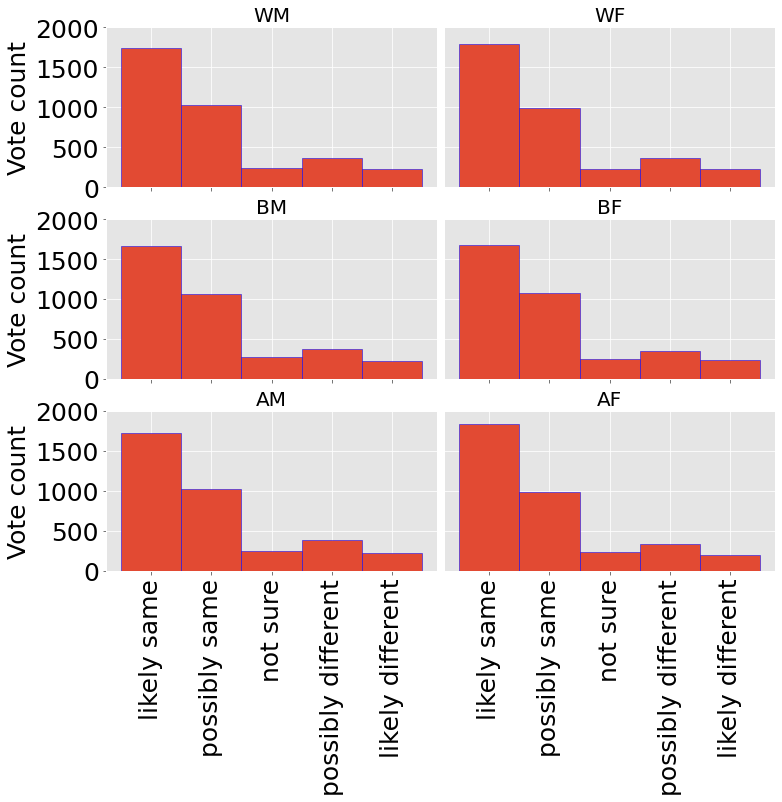

In [53]:
fig4, ax4 = plt.subplots(figsize=(12, 10))
font1 = {'color':'black','size':25}
for i in range(6):
    plt.subplot(3,2,i+1)
    x = same_grp[list(same_grp.keys())[i]]
    plt.style.use('ggplot')
    n, bins, patches  = plt.hist(x, bins=[0,1,2,3,4,5], edgecolor='blue')
    plt.title(['WM', 'WF', 'BM', 'BF', 'AM', 'AF', ][i], fontsize=20)
    if i in [4,5]:
        plt.xticks([0.5,1.5,2.5,3.5,4.5], ['likely same', 'possibly same', 'not sure', 'possibly different', 'likely different'], fontdict=font1, rotation=90)
    else:
        plt.xticks([0.5,1.5,2.5,3.5,4.5], ['']*5)
    if i in [1,3,5]:
        plt.tick_params(left = False, right = False , labelleft = False)
    else:
        plt.ylabel('Vote count', fontdict = font1)
    plt.yticks(fontsize=25, color='black')
    plt.ylim(0,2000)
fig4.subplots_adjust(wspace=0.02)
plt.savefig("final_plots/pose/hist_human_pose_sameID_000.jpg", bbox_inches = "tight")
plt.show()

In [18]:
diff_id = {'whitemale':[],
           'whitefemale':[], 
           'blackmale':[], 
           'blackfemale':[], 
           'asianmale':[], 
           'asianfemale':[],}
for i in range(len(idx_map)):
    id1,gr1,attr1,id2,gr2,attr2, task  = extract_ID_gender_race(idx_map[i])
    if task == 'pose':
        if id1 != id2 and gr1 == gr2:
            diff_id[gr1].extend(scores[i])

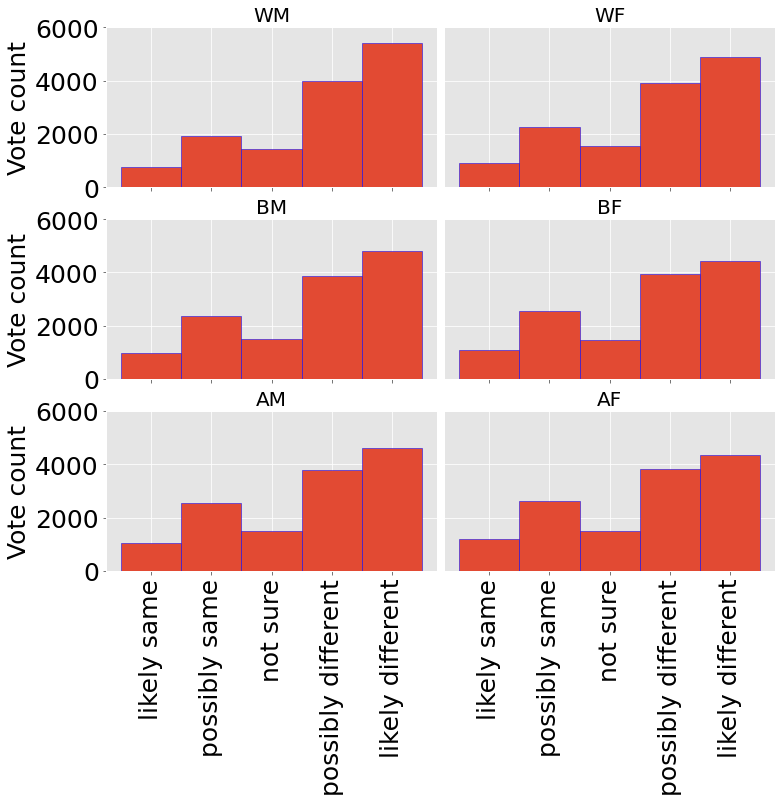

In [22]:
fig4, ax4 = plt.subplots(figsize=(12, 10))
font1 = {'color':'black','size':25}
for i in range(6):
    plt.subplot(3,2,i+1)
    x = diff_id[list(diff_id.keys())[i]]
    plt.style.use('ggplot')
    n, bins, patches  = plt.hist(x, bins=[0,1,2,3,4,5], edgecolor='blue')
    plt.title(['WM', 'WF', 'BM', 'BF', 'AM', 'AF', ][i], fontsize=20)
    if i in [4,5]:
        plt.xticks([0.5,1.5,2.5,3.5,4.5], ['likely same', 'possibly same', 'not sure', 'possibly different', 'likely different'], fontdict=font1, rotation=90)
    else:
        plt.xticks([0.5,1.5,2.5,3.5,4.5], ['']*5)
    if i in [1,3,5]:
        plt.tick_params(left = False, right = False , labelleft = False)
    else:
        plt.ylabel('Vote count', fontdict = font1)
    plt.yticks([0,2000,4000,6000],fontsize=25, color='black')
    plt.ylim(0,6000)
fig4.subplots_adjust(wspace=0.02)
plt.savefig("final_plots/pose/hist_human_pose_diffID_000.jpg", bbox_inches = "tight")
plt.show()

# HCC as ground truth label

In [162]:
positive_pair = {'whitemale':[],
           'whitefemale':[], 
           'blackmale':[], 
           'blackfemale':[], 
           'asianmale':[], 
           'asianfemale':[],}

negative_pair = {'whitemale':[],
           'whitefemale':[], 
           'blackmale':[], 
           'blackfemale':[], 
           'asianmale':[], 
           'asianfemale':[],}

for i in range(len(idx_map)):
    id1,gr1,attr1,id2,gr2,attr2, task  = extract_ID_gender_race(idx_map[i])
    if task == 'pose':
        hcc = np.mean(scores[i])
        if gr1 != gr2:
            print('found invalid pair')
        if hcc<=1.1:
            positive_pair[gr1].append([id1,gr1,attr1,id2,gr2,attr2])
        else:
            negative_pair[gr1].append([id1,gr1,attr1,id2,gr2,attr2])

In [173]:
import cv2
from iresnet import iresnet34, iresnet18

weight = '/scratch/hl106/pretrained_models/face_reco_models/R34_MS1MV3.pth'
net = iresnet34(fp16=False)
net.load_state_dict(torch.load(weight))
net.eval()
net.cuda()
# import sys
# sys.path.append('../../opensphere')
# from builder import build_from_cfg
# cfg = {'type': 'sfnet20_deprecated', 'in_channel': 3, 'channels': [64, 128, 256, 512], 'out_channel': 512}
# net = build_from_cfg(cfg, 'model.backbone')
# tmp_model = torch.load('/scratch/hl106/20220501_194024/models/backbone_90000.pth')
# for key in list(tmp_model.keys()):
#     tmp_model[key[7:]] = tmp_model.pop(key)
# net.load_state_dict(tmp_model)
# net.eval()
# net.cuda()

def img2feat(net, file_name):
    img = cv2.imread(file_name)
    img = cv2.resize(img, (112, 112))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float().cuda()
    img.div_(255).sub_(0.5).div_(0.5)

    
    feat = net(img).cpu().detach().numpy()
    feat /= np.linalg.norm(feat)
    return feat.reshape(512)

In [174]:
# False non match -- positive reconized as negative
attr = [-3.0,-1.5,0.0,1.5,3.0]
dist_dict_fnm = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        dist_dict_fnm[f'{race}_{gender}'] = []
        curr_list = positive_pair[f'{race}{gender}']
        for i in curr_list:
            feat1 = img2feat(net, f'out/final_picked_pose/seed_{i[0]}/{race}_{gender}_y_{attr[int(i[2])]}_o2_rm_bg.png')
            feat2 = img2feat(net, f'out/final_picked_pose/seed_{i[3]}/{race}_{gender}_y_{attr[int(i[-1])]}_o2_rm_bg.png')
            dist_dict_fnm[f'{race}_{gender}'].append(np.dot(feat1, feat2))

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:51<00:00, 37.10s/it]


In [175]:
# False match -- negativereconized as postitive
attr = [-3.0,-1.5,0.0,1.5,3.0]
dist_dict_fm = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        dist_dict_fm[f'{race}_{gender}'] = []
        curr_list = negative_pair[f'{race}{gender}']
        for i in curr_list:
            feat1 = img2feat(net, f'out/final_picked_pose/seed_{i[0]}/{race}_{gender}_y_{attr[int(i[2])]}_o2_rm_bg.png')
            feat2 = img2feat(net, f'out/final_picked_pose/seed_{i[3]}/{race}_{gender}_y_{attr[int(i[-1])]}_o2_rm_bg.png')
            dist_dict_fm[f'{race}_{gender}'].append(np.dot(feat1, feat2))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [14:27<00:00, 289.26s/it]


In [176]:
fmr = {}
fnmr = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        fm = dist_dict_fm[f'{race}_{gender}']
        fnm = dist_dict_fnm[f'{race}_{gender}']
        fmr[f'{race}_{gender}'] = []
        fnmr[f'{race}_{gender}'] = []
        for t in range(0, 1000):
            m_cnt = 0
            for i in fm:
                if i >= t/1000:
                    m_cnt += 1
            fmr[f'{race}_{gender}'].append(m_cnt/len(fm))   
                
            nm_cnt = 0
            for i in fnm:
                if i < t/1000:
                    nm_cnt += 1
            fnmr[f'{race}_{gender}'].append(nm_cnt/len(fnm))   

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.84s/it]


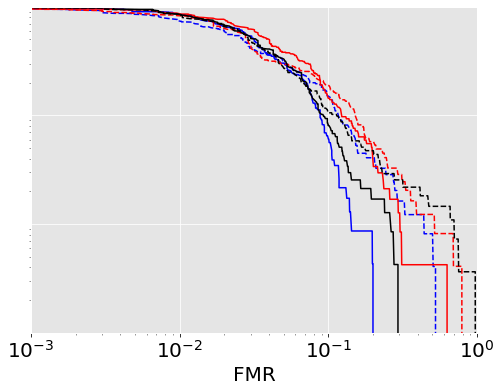

In [177]:
from matplotlib import pyplot as plt
fig4, ax4 = plt.subplots(figsize=(8,6))
colors = ['b', 'r', 'k', 'm', 'c', 'y']
labels = ['WM', 'WF','BM', 'BF','AM', 'AF',]
for i, race in enumerate(['white', 'black', 'asian']):
    for g, gender in enumerate(['male', 'female']):
        if gender == 'female':
            ax4.plot(fmr[f'{race}_{gender}'], fnmr[f'{race}_{gender}'], label = labels[2*i+g],linestyle='dashed', color=colors[i])
        else:
            ax4.plot(fmr[f'{race}_{gender}'], fnmr[f'{race}_{gender}'], label = labels[2*i+g], color=colors[i])
            
legend_properties = {'size':15}
ax4.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
ax4.tick_params(axis='y', colors='black')
ax4.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
ax4.yaxis.label.set_color('black')
# ax4.set_yticks([])
ax4.set_xlim(1e-3, 1)
ax4.set_ylim(1e-3, 1)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(loc='lower left', fontsize=20, prop=legend_properties)
# plt.ylabel("FNMR", fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False)
plt.xlabel("FMR", fontsize=20)
plt.savefig("final_plots/pose/res34_ms1mv3_hcc1.1_FNMR_FMR_pose.jpg", bbox_inches = "tight")
plt.show()

# scatter plot: HCC vs cos dist

In [317]:
same_pair = {'whitemale':[],
           'whitefemale':[], 
           'blackmale':[], 
           'blackfemale':[], 
           'asianmale':[], 
           'asianfemale':[],}

diff_pair = {'whitemale':[],
           'whitefemale':[], 
           'blackmale':[], 
           'blackfemale':[], 
           'asianmale':[], 
           'asianfemale':[],}

for i in range(len(idx_map)):
    id1,gr1,attr1,id2,gr2,attr2, task  = extract_ID_gender_race(idx_map[i])
    if task == 'pose':
        hcc = np.mean(scores[i])
        if gr1 != gr2:
            print('found invalid pair')
        if id1 == id2:
            same_pair[gr1].append([id1,gr1,attr1,id2,gr2,attr2, hcc])
        else:
            diff_pair[gr1].append([id1,gr1,attr1,id2,gr2,attr2, hcc])

In [319]:
diff_pair['whitemale'][0]

['30087', 'whitemale', '2', '32850', 'whitemale', '0', 3.0]

In [322]:
same_scores = []
attr = [-3.0,-1.5,0.0,1.5,3.0]
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        curr_list = same_pair[f'{race}{gender}']
        for i in curr_list:
            feat1 = img2feat(net, f'out/final_picked_pose/seed_{i[0]}/{race}_{gender}_y_{attr[int(i[2])]}_o2_rm_bg.png')
            feat2 = img2feat(net, f'out/final_picked_pose/seed_{i[3]}/{race}_{gender}_y_{attr[int(i[-2])]}_o2_rm_bg.png')
            same_scores.append([np.dot(feat1, feat2), i[-1]])

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:55<00:00, 38.51s/it]


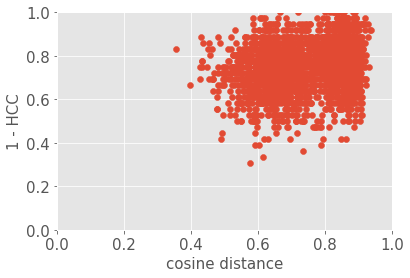

In [343]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array(same_scores)[:,0]
y = 1-(np.array(same_scores)[:,1]/4)
plt.figure(figsize=(6,4))
plt.scatter(x, y)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('cosine distance', fontsize=15)
plt.ylabel('1 - HCC', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('final_plots/pose/scatter_hcc_cosDist_sameID.jpg',  bbox_inches = "tight")
plt.show()

In [335]:
diff_scores = []

attr = [-3.0,-1.5,0.0,1.5,3.0]
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        curr_list = diff_pair[f'{race}{gender}']
        for i in curr_list:
            feat1 = img2feat(net, f'out/final_picked_pose/seed_{i[0]}/{race}_{gender}_y_{attr[int(i[2])]}_o2_rm_bg.png')
            feat2 = img2feat(net, f'out/final_picked_pose/seed_{i[3]}/{race}_{gender}_y_{attr[int(i[-2])]}_o2_rm_bg.png')
            diff_scores.append([np.dot(feat1, feat2), i[-1]])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:18<00:00, 146.06s/it]


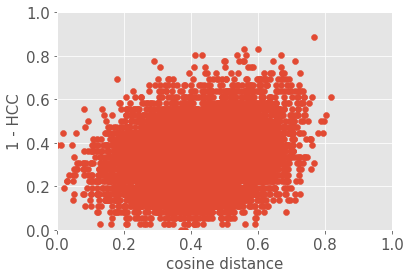

In [344]:
x = np.array(diff_scores)[:,0]
y = 1-(np.array(diff_scores)[:,1]/4)
plt.figure(figsize=(6,4))
plt.scatter(x, y)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('cosine distance', fontsize=15)
plt.ylabel('1 - HCC', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('final_plots/pose/scatter_hcc_cosDist_diffID.jpg',  bbox_inches = "tight")
plt.show()

# fiducial ground truth 

In [235]:
fmr = {}
fnmr = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        fm = diff_id[f'{race}{gender}']
        fnm = same_grp[f'{race}{gender}']
        
        fmr[f'{race}_{gender}'] = []
        fnmr[f'{race}_{gender}'] = []
        for t in [0.5,1.5,2.5,3.5,4.5]:
            m_cnt = 0
            for i in fm:
                if i >= t:
                    m_cnt += 1
            fmr[f'{race}_{gender}'].append(m_cnt/len(fm))   
                
            nm_cnt = 0
            for i in fnm:
                if i < t:
                    nm_cnt += 1
            fnmr[f'{race}_{gender}'].append(nm_cnt/len(fnm))   


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.99it/s]


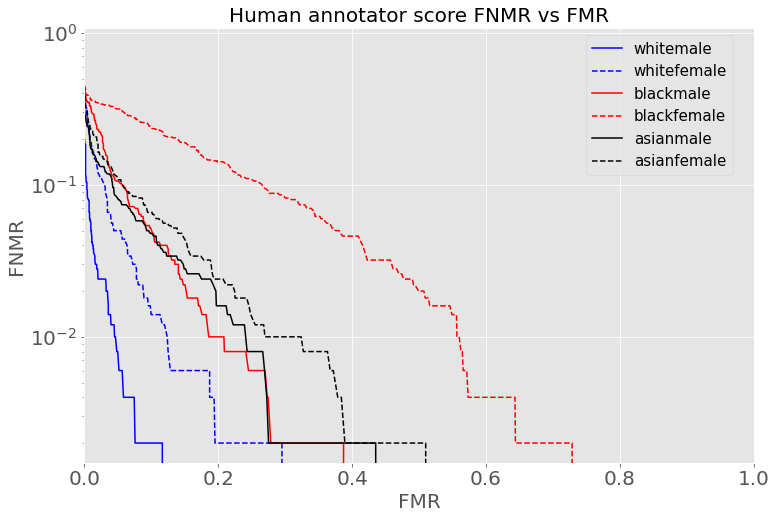

In [271]:
from matplotlib import pyplot as plt
colors = ['b', 'r', 'k', 'm', 'c', 'y']
# x = np.arange(5)
# model = ["Kernel 3", "Kernel 5", "Kernel 7", "Kernel 11","Kernel 13"]
# mode = ['Original', "High", "Low"]
plt.figure(figsize=(12,8))
for i, race in enumerate(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        if gender == 'female':
            plt.plot(fmr[f'{race}_{gender}'], fnmr[f'{race}_{gender}'], label=f'{race}{gender}', linestyle='dashed', color=colors[i])
        else:
            plt.plot(fmr[f'{race}_{gender}'], fnmr[f'{race}_{gender}'], label=f'{race}{gender}', color=colors[i])
# plt.ylim(0.7, 1)
plt.xlim(0, 1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yscale('log')
# plt.xscale('log')

plt.legend(bbox_to_anchor=(0.98, 1), fontsize=15)
plt.ylabel("FNMR", fontsize=20)
plt.title("Human annotator score FNMR vs FMR", fontsize=20)
plt.xlabel("FMR", fontsize=20)
# plt.xscale('log')
plt.yscale('log')
# plt.grid()
plt.savefig("final_plots/pose/human_annotator_score_FNMR_FMR_pose_000.jpg", bbox_inches = "tight")
plt.show()

In [242]:
#FNMR
attr = [-3.0,-1.5,0.0,1.5,3.0]
dist_dict_fnm = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        dist_dict_fnm[f'{race}_{gender}'] = []
        for seed in target_seeds:
            dists = []
            for i, ra in enumerate(ages):
                feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed}/{race}_{gender}_y_{0.0}_o2_rm_bg.png')
                feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed}/{race}_{gender}_y_{ra}_o2_rm_bg.png')
                dist_dict_fnm[f'{race}_{gender}'].append(np.dot(feat1, feat2))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:48<00:00, 56.30s/it]


In [245]:
dist_dict_fm = {}
ages = [-3.0,-1.5,0.0,1.5,3.0]
age_pairs = [[2,0], [2,1], [2,2], [2,3], [2,4]]
np.random.seed(3)

for race in ['white', 'black', 'asian']:
    for gender in ['male', 'female']:
        dist_dict_fm[f'{race}_{gender}'] = []
        for seed1 in target_seeds:
            tmp = target_seeds.copy()
            tmp.remove(seed1)
            choice = np.random.choice(tmp, size=3, replace=False)
            for j in range(3):
                seed2 = choice[j]
                for p in age_pairs:
                    feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed1}/{race}_{gender}_y_{ages[p[0]]}_o2_rm_bg.png')
                    feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed2}/{race}_{gender}_y_{ages[p[1]]}_o2_rm_bg.png')
                    dist_dict_fm[f'{race}_{gender}'].append(np.dot(feat1, feat2))

In [256]:
fmr = {}
fnmr = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        fm = dist_dict_fm[f'{race}_{gender}']
        fnm = dist_dict_fnm[f'{race}_{gender}']
        fmr[f'{race}_{gender}'] = []
        fnmr[f'{race}_{gender}'] = []
        for t in range(0, 1000):
            m_cnt = 0
            for i in fm:
                if i >= t/1000:
                    m_cnt += 1
            fmr[f'{race}_{gender}'].append(m_cnt/len(fm))   
                
            nm_cnt = 0
            for i in fnm:
                if i < t/1000:
                    nm_cnt += 1
            fnmr[f'{race}_{gender}'].append(nm_cnt/len(fnm))   


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.61s/it]


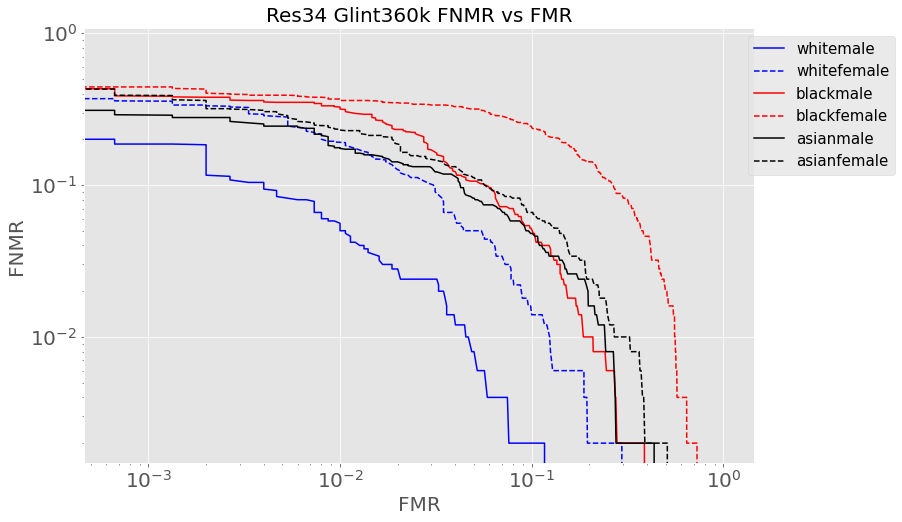

In [265]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
colors = ['b', 'r', 'k', 'm', 'c', 'y']
# x = np.arange(5)
# model = ["Kernel 3", "Kernel 5", "Kernel 7", "Kernel 11","Kernel 13"]
# mode = ['Original', "High", "Low"]
# plt.figure(figsize=(6,4))
for i, race in enumerate(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        if gender == 'female':
            plt.plot(fmr[f'{race}_{gender}'], fnmr[f'{race}_{gender}'], label=f'{race}{gender}', linestyle='dashed', color=colors[i])
        else:
            plt.plot(fmr[f'{race}_{gender}'], fnmr[f'{race}_{gender}'], label=f'{race}{gender}', color=colors[i])
#         plt.ylim(0.05, 0.16)
#         plt.xlim(0, 0.1)
        
#         plt.legend(bbox_to_anchor=(0.98, 1), fontsize=8)
        # plt.title("X-ray recognition")
        # plt.grid()
        # plt.savefig("plots/VAL.pdf")
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(0.98, 1), fontsize=15)
plt.ylabel("FNMR", fontsize=20)
plt.title("Res34 Glint360k FNMR vs FMR", fontsize=20)
plt.xlabel("FMR", fontsize=20)
plt.savefig("final_plots/pose/res34_glint340k_score_FNMR_FMR_pose.jpg", bbox_inches = "tight")
plt.show()

# Model eval

In [84]:
import cv2
from iresnet import iresnet34, iresnet18

# weight = '/scratch/hl106/pretrained_models/face_reco_models/R34_Glint360k.pth'
# net = iresnet34(fp16=False)
# net.load_state_dict(torch.load(weight))
# net.eval()
# net.cuda()

import sys
sys.path.append('../../opensphere')
from builder import build_from_cfg
cfg = {'type': 'sfnet20_deprecated', 'in_channel': 3, 'channels': [64, 128, 256, 512], 'out_channel': 512}
net = build_from_cfg(cfg, 'model.backbone')
tmp_model = torch.load('/scratch/hl106/20220501_194024/models/backbone_90000.pth')
for key in list(tmp_model.keys()):
    tmp_model[key[7:]] = tmp_model.pop(key)
net.load_state_dict(tmp_model)
net.eval()
net.cuda()

def img2feat(net, file_name):
    img = cv2.imread(file_name)
    img = cv2.resize(img, (112, 112))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float().cuda()
    img.div_(255).sub_(0.5).div_(0.5)

    
    feat = net(img).cpu().detach().numpy()
    feat /= np.linalg.norm(feat)
    return feat.reshape(512)

In [85]:
angles = [-3.0, -1.5, 0.0, 1.5, 3.0]
same_same_dist_dict = {}
for race in tqdm(['white', 'black', 'asian']):
    for gender in ['male', 'female']:
        same_same_dist_dict[f'{race}_{gender}'] = {i:[] for i in range(5)}
        for seed in target_seeds:
            for j in range(5):
                feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed}/{race}_{gender}_y_{0.0}_o2_rm_bg.png')
                feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed}/{race}_{gender}_y_{angles[j]}_o2_rm_bg.png')
                same_same_dist_dict[f'{race}_{gender}'][j].append(np.dot(feat1, feat2))

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:43<00:00, 34.35s/it]


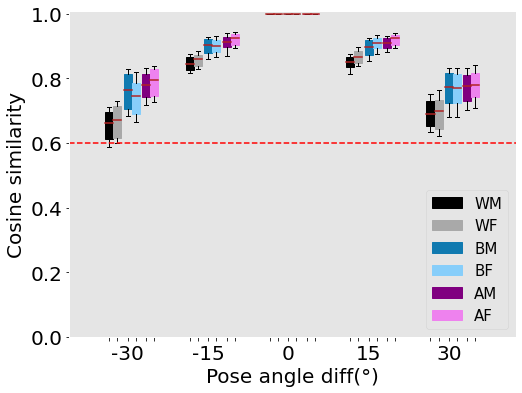

In [86]:
colors = ['black', 'darkgrey', 'xkcd:nice blue', 'lightskyblue', 'purple', 'violet']
pairs = ['white_male', 'white_female', 'black_male', 'black_female', 'asian_male', 'asian_female', ]
plt.style.use('ggplot')
fig4, ax4 = plt.subplots(figsize=(8,6))
# ax4.set_title('Cosine similarity-pose: same race/gender same seed R34_glint360k', fontsize=30)
angles = [-30, -15, 0, 15, 30]
non_angles = ['']*5
boxes = []
labels = ['WM', 'WF','BM', 'BF','AM', 'AF',]
for i in range(6):
    curr_data = np.zeros((100,5))
    for j in range(5):
        curr_data[:,j] = same_same_dist_dict[pairs[i]][j]
    if i == 2:
        box1 = ax4.boxplot(np.array(curr_data), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 
                               4.1+0.1*i+0.03*(i//2)],
                    widths=0.1, 
                    labels=angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )

    else:
         box1 = ax4.boxplot(np.array(curr_data), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 
                               4.1+0.1*i+0.03*(i//2)],
                    widths=0.1,
                    labels=non_angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )
    boxes.append(box1)
    
legend_properties = {'size':15}
for i in range(6): 
    ax4.legend([boxes[i]["boxes"][0] for i in range(6)], [labels[i] for i in range(6)], loc='lower right', prop=legend_properties)

# ax4.set_facecolor("gai")
ax4.set_ylim(0,1.01)
ax4.grid()
ax4.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
ax4.tick_params(axis='y', colors='black')

ax4.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
ax4.yaxis.label.set_color('black')
ax4.axhline(y=0.6, color='red', linestyle='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax4.set_xlabel('Pose angle diff(°)', fontsize=20)
ax4.set_ylabel('Cosine similarity', fontsize=20)
plt.savefig("final_plots/pose/same_seed_same_race_gender_cos_similarity_pose_sff_vgg_15_85_ci.jpg", bbox_inches = "tight")

In [87]:
diff_same_dict = {}
# seeds = [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]
attr = [-3.0,-1.5,0.0,1.5,3.0]
attr_pairs = [[2,0], [2,1], [2,2], [2,3], [2,4]]
np.random.seed(3)

for race in ['white', 'black', 'asian']:
    for gender in ['male', 'female']:
        diff_same_dict [f'{race}_{gender}'] = []
        for seed1 in target_seeds:
            tmp = target_seeds.copy()
            tmp.remove(seed1)
            choice = np.random.choice(tmp, size=3, replace=False)
            for j in range(3):
                seed2 = choice[j]
                dists = []
                for p in attr_pairs:
                    feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed1}/{race}_{gender}_y_{attr[p[0]]}_o2_rm_bg.png')
                    feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed2}/{race}_{gender}_y_{attr[p[1]]}_o2_rm_bg.png')
                    dists.append(np.dot(feat1, feat2))
                diff_same_dict [f'{race}_{gender}'].append(dists)

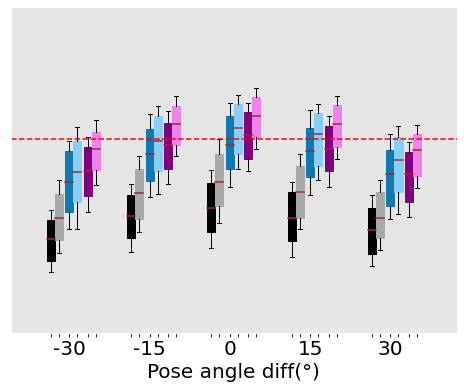

In [88]:
colors = ['black', 'darkgrey', 'xkcd:nice blue', 'lightskyblue', 'purple', 'violet']
fig4, ax4 = plt.subplots(figsize=(8,6))
# ax4.set_title('Cosine similarity-pose: same race/gender different seed R34_glint360k', fontsize=30)
angles = [-30, -15, 0, 15, 30]
non_angles = ['']*5
boxes = []
for i in range(6):
    if i == 2:
        box1 = ax4.boxplot(np.array(diff_same_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)],
                    widths=0.1, 
                    labels=angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )

    else:
         box1 = ax4.boxplot(np.array(diff_same_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)],
                    widths=0.1,
                    labels=non_angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )
    boxes.append(box1)

legend_properties = {'size':15}
# for i in range(6): 
#     ax4.legend([boxes[i]["boxes"][0] for i in range(6)], [pairs[i] for i in range(6)], loc='upper left', prop=legend_properties)

ax4.set_yticks([])
ax4.set_ylim(0,1.01)
ax4.grid()
ax4.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red

ax4.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
ax4.yaxis.label.set_color('black')
ax4.axhline(y=0.6, color='red', linestyle='--')
plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
ax4.set_xlabel('Pose angle diff(°)', fontsize=20)
# ax4.set_ylabel('Cosine similarity', fontsize=20)
plt.savefig("final_plots/pose/diff_seed_same_race_gender_cos_similarity_pose_sff_vgg_15_85_ci.jpg", bbox_inches = "tight")
# plt.grid()
# ax4.set_xticks(fontsize=30)

In [89]:
pairs = ['white_male', 'white_female', 'black_male', 'black_female', 'asian_male', 'asian_female', ]
diff_diff_dict = {i:[] for i in pairs}
races = [
    ['white', 'male', 'black', 'female'],
    ['white', 'male', 'asian', 'female'],
    ['white', 'female', 'asian', 'male'],
    ['white', 'female', 'black', 'male'],
    
    ['black', 'male', 'asian', 'female'],
    ['black', 'male', 'white', 'female'],
    ['black', 'female', 'asian', 'male'],
    ['black', 'female', 'white', 'male'],
    
    ['asian', 'male', 'white', 'female'],
    ['asian', 'male', 'white', 'female'],
    ['asian', 'female', 'black', 'male'],
    ['asian', 'female', 'black', 'male'],
    
]
np.random.seed(3)
# seeds = [5022, 5213, 5336, 5471, 5494, 5615, 5783, 5840, 5896, 5916]
for i in range(6):
    for j in range(2*i, 2*i+2):
        for seed1 in target_seeds:
            tmp = target_seeds.copy()
            tmp.remove(seed1)
            choice = np.random.choice(tmp, size=3, replace=False)
            for j in range(3):
                seed2 = choice[j]
                dists = []
                for pose in [-3.0, -1.5, 0.0, 1.5, 3.0]:
                    feat1 = img2feat(net, f'out/final_picked_pose/seed_{seed1}/{races[j][0]}_{races[j][1]}_y_{0.0}_o2_rm_bg.png')
                    feat2 = img2feat(net, f'out/final_picked_pose/seed_{seed2}/{races[j][2]}_{races[j][3]}_y_{pose}_o2_rm_bg.png')
                    dists.append(np.dot(feat1, feat2))
                diff_diff_dict[pairs[i]].append(dists)

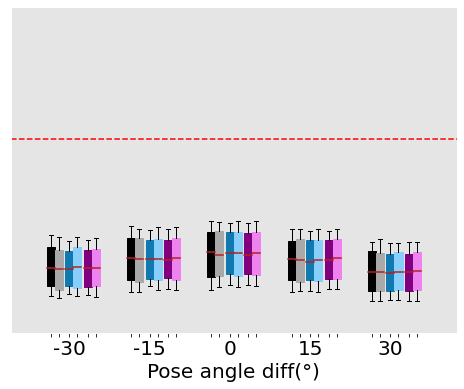

In [90]:
colors = ['black', 'darkgrey', 'xkcd:nice blue', 'lightskyblue', 'purple', 'violet']
fig4, ax4 = plt.subplots(figsize=(8,6))
# ax4.set_title('Cosine similarity-pose: same race/gender different seed R34_glint360k', fontsize=30)
angles = [-30, -15, 0, 15, 30]
non_angles = ['']*5
boxes = []
for i in range(6):
    if i == 2:
        box1 = ax4.boxplot(np.array(diff_diff_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)],
                    widths=0.1, 
                    labels=angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )

    else:
         box1 = ax4.boxplot(np.array(diff_diff_dict[pairs[i]]), 
                    showfliers=False,
#                     notch=True,
                    patch_artist=True,
                    whis=[15,85], 
                    positions=[0.1+0.1*i+0.03*(i//2), 1.1+0.1*i+0.03*(i//2), 2.1+0.1*i+0.03*(i//2), 3.1+0.1*i+0.03*(i//2), 4.1+0.1*i+0.03*(i//2)],
                    widths=0.1,
                    labels=non_angles,
                    boxprops=dict(color=colors[i], facecolor=colors[i]),
                    medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
                   )
    boxes.append(box1)

legend_properties = {'size':15}
# for i in range(6): 
#     ax4.legend([boxes[i]["boxes"][0] for i in range(6)], [pairs[i] for i in range(6)], loc='upper left', prop=legend_properties)

ax4.set_yticks([])
ax4.set_ylim(0,1.01)
ax4.grid()
ax4.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red

ax4.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
ax4.yaxis.label.set_color('black')
ax4.axhline(y=0.6, color='red', linestyle='--')
plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
ax4.set_xlabel('Pose angle diff(°)', fontsize=20)
# ax4.set_ylabel('Cosine similarity', fontsize=20)
plt.savefig("final_plots/pose/diff_seed_diff_race_gender_cos_similarity_pose_sff_vgg_15_85_ci.jpg", bbox_inches = "tight")
# plt.grid()
# ax4.set_xticks(fontsize=30)

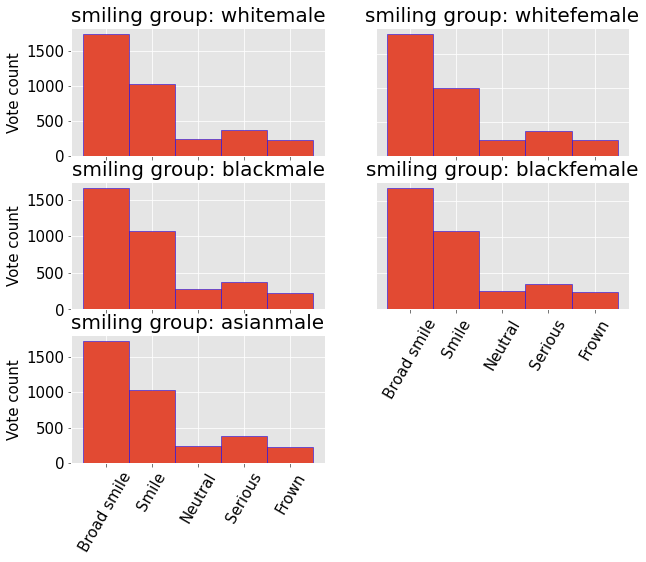

In [436]:
fig4, ax4 = plt.subplots(figsize=(10,8))
font1 = {'color':'black','size':15}
for i in range(5):
    plt.subplot(3,2,i+1)
    x = same_grp[list(same_grp.keys())[i]]
    plt.style.use('ggplot')
    with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
        n, bins, patches  = plt.hist(x, bins=[0,1,2,3,4,5], edgecolor='blue')
    plt.title(f'smiling group: {list(same_grp.keys())[i]}', fontsize=20)
    if i in [3,4]:
        plt.xticks([0.5,1.5,2.5,3.5,4.5], ['Broad smile', 'Smile', 'Neutral', 'Serious', 'Frown'], fontdict=font1, rotation=60)
    else:
        plt.xticks([0.5,1.5,2.5,3.5,4.5], ['']*5)

    plt.yticks(fontsize=15, color='black')
    if i in [1,3]:
        plt.tick_params(left = False, right = False , labelleft = False)
    else:
        plt.ylabel('Vote count', fontdict = font1)
    
plt.savefig("final_plots/single/hist_human_smiling_020.jpg", bbox_inches = "tight")
plt.show()